## Advisory 
### If you have not yet begun the project 
Please do not use this workspace.  Use the AWS resources provided and the instructions from the [cloud computing lesson](https://classroom.udacity.com/nanodegrees/nd101/parts/b9c4c3c3-b524-427b-8832-9d0748f14a2e/modules/de12f7bf-d980-4998-ab91-0e411184c878/lessons/29df00d8-01c2-4995-92fa-a4afd020be90/concepts/80d2ed46-1bba-413e-891e-610259017251).
### If you have started on this workspace
Please consider downloading your Jupyter notebook and then following the instructions above on using AWS instead.  You can upload your current work to AWS through your GitHub account.  


As a reminder, the project can be found on the [deep learning GitHub page](https://github.com/udacity/deep-learning/tree/master/face_generation).
These warnings are given because the project frequently generates more data than the workspace can handle, causing loading problems and lost work.  Please use [the forums](https://discussions.udacity.com/c/nd101-part-5-GANs/nd101-generate-faces) if you have any questions on the project or its setup.


# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

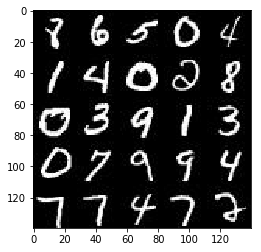

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

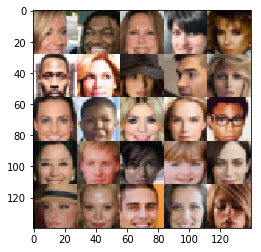

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/Users/nma/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.8.0


/Users/nma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], 'real_input_images')
    input_z = tf.placeholder(tf.float32, [None, z_dim], 'input_z')
    learning_rate = tf.placeholder(tf.float32, [], 'learning_rate')
    return real_input_images, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2, keep_prob=0.5):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xn
        conv1 = tf.layers.conv2d(images, 64, 5, 2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        drop1 = tf.layers.dropout(lrelu1, keep_prob)
        
        conv2 = tf.layers.conv2d(drop1, 128, 5, 2, 'same', use_bias=False)
        bn2 = tf.layers.batch_normalization(conv2)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.layers.dropout(lrelu2, keep_prob)
        
        conv3 = tf.layers.conv2d(drop2, 256, 5, 2, 'same', use_bias=False)
        bn3 = tf.layers.batch_normalization(conv3)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.layers.dropout(lrelu3, keep_prob)
        
        flat = tf.reshape(drop3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, keep_prob=0.5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        fc = tf.layers.dense(z, 4*4*1024, use_bias=False)
        fc = tf.reshape(fc, (-1, 4, 4, 1024))
        bn0 = tf.layers.batch_normalization(fc, training=is_train)
        lrelu0 = tf.maximum(alpha * bn0, bn0)
        drop0 = tf.layers.dropout(lrelu0, keep_prob, training=is_train)
        
        conv1 = tf.layers.conv2d_transpose(drop0, 512, 4, 1, 'valid', use_bias=False)
        bn1 = tf.layers.batch_normalization(conv1, training=is_train)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        drop1 = tf.layers.dropout(lrelu1, keep_prob, training=is_train)
        
        conv2 = tf.layers.conv2d_transpose(drop1, 256, 5, 2, 'same', use_bias=False)
        bn2 = tf.layers.batch_normalization(conv2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.layers.dropout(lrelu2, keep_prob, training=is_train)
        
        logits = tf.layers.conv2d_transpose(drop2, out_channel_dim, 5, 2, 'same')
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth_factor=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real) * (1 - smooth_factor)))
    
    input_fake = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(input_fake, reuse=True, alpha=alpha)
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    return d_loss_real + d_loss_fake, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
          print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{} Step {}...".format(epoch_i+1, epoch_count, steps),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))  

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode) 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Step 10... Discriminator Loss: 1.3551... Generator Loss: 0.6710
Epoch 1/2 Step 20... Discriminator Loss: 1.3521... Generator Loss: 0.7863
Epoch 1/2 Step 30... Discriminator Loss: 1.2584... Generator Loss: 0.6745
Epoch 1/2 Step 40... Discriminator Loss: 1.2290... Generator Loss: 0.9226
Epoch 1/2 Step 50... Discriminator Loss: 1.2650... Generator Loss: 1.0591
Epoch 1/2 Step 60... Discriminator Loss: 1.1425... Generator Loss: 0.8163
Epoch 1/2 Step 70... Discriminator Loss: 1.0744... Generator Loss: 1.1010
Epoch 1/2 Step 80... Discriminator Loss: 1.8916... Generator Loss: 0.2529
Epoch 1/2 Step 90... Discriminator Loss: 0.9984... Generator Loss: 1.0748
Epoch 1/2 Step 100... Discriminator Loss: 1.4455... Generator Loss: 1.0930


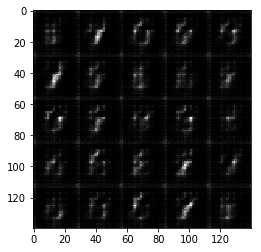

Epoch 1/2 Step 110... Discriminator Loss: 1.4510... Generator Loss: 0.7553
Epoch 1/2 Step 120... Discriminator Loss: 1.1627... Generator Loss: 0.9607
Epoch 1/2 Step 130... Discriminator Loss: 1.5801... Generator Loss: 1.3320
Epoch 1/2 Step 140... Discriminator Loss: 1.0057... Generator Loss: 1.3701
Epoch 1/2 Step 150... Discriminator Loss: 1.1920... Generator Loss: 1.0870
Epoch 1/2 Step 160... Discriminator Loss: 1.9335... Generator Loss: 0.2767
Epoch 1/2 Step 170... Discriminator Loss: 1.3246... Generator Loss: 0.8766
Epoch 1/2 Step 180... Discriminator Loss: 1.2472... Generator Loss: 0.8180
Epoch 1/2 Step 190... Discriminator Loss: 1.2191... Generator Loss: 0.9055
Epoch 1/2 Step 200... Discriminator Loss: 1.2703... Generator Loss: 1.0484


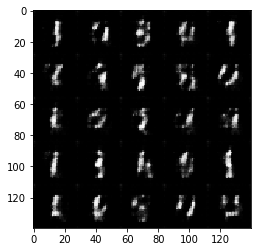

Epoch 1/2 Step 210... Discriminator Loss: 1.3152... Generator Loss: 0.7346
Epoch 1/2 Step 220... Discriminator Loss: 1.3330... Generator Loss: 0.9263
Epoch 1/2 Step 230... Discriminator Loss: 1.3091... Generator Loss: 0.8615
Epoch 1/2 Step 240... Discriminator Loss: 1.3415... Generator Loss: 1.2363
Epoch 1/2 Step 250... Discriminator Loss: 1.4153... Generator Loss: 0.7283
Epoch 1/2 Step 260... Discriminator Loss: 1.2277... Generator Loss: 1.2364
Epoch 1/2 Step 270... Discriminator Loss: 1.3130... Generator Loss: 1.0708
Epoch 1/2 Step 280... Discriminator Loss: 1.3802... Generator Loss: 0.7192
Epoch 1/2 Step 290... Discriminator Loss: 1.1231... Generator Loss: 1.1445
Epoch 1/2 Step 300... Discriminator Loss: 1.3662... Generator Loss: 1.1556


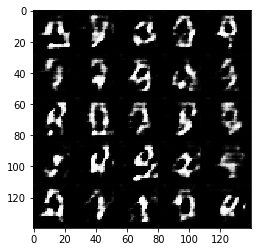

Epoch 1/2 Step 310... Discriminator Loss: 1.1019... Generator Loss: 0.8522
Epoch 1/2 Step 320... Discriminator Loss: 1.0848... Generator Loss: 0.8684
Epoch 1/2 Step 330... Discriminator Loss: 1.0598... Generator Loss: 1.3328
Epoch 1/2 Step 340... Discriminator Loss: 1.3348... Generator Loss: 0.9357
Epoch 1/2 Step 350... Discriminator Loss: 1.2852... Generator Loss: 1.0167
Epoch 1/2 Step 360... Discriminator Loss: 1.1974... Generator Loss: 0.9267
Epoch 1/2 Step 370... Discriminator Loss: 1.2392... Generator Loss: 0.8086
Epoch 1/2 Step 380... Discriminator Loss: 1.3191... Generator Loss: 0.9467
Epoch 1/2 Step 390... Discriminator Loss: 1.3002... Generator Loss: 0.8104
Epoch 1/2 Step 400... Discriminator Loss: 1.2999... Generator Loss: 0.7469


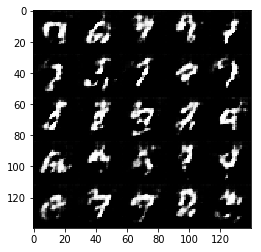

Epoch 1/2 Step 410... Discriminator Loss: 1.1352... Generator Loss: 0.9431
Epoch 1/2 Step 420... Discriminator Loss: 1.3325... Generator Loss: 1.0640
Epoch 1/2 Step 430... Discriminator Loss: 1.2628... Generator Loss: 1.0589
Epoch 1/2 Step 440... Discriminator Loss: 1.2257... Generator Loss: 0.9801
Epoch 1/2 Step 450... Discriminator Loss: 1.2078... Generator Loss: 0.9717
Epoch 1/2 Step 460... Discriminator Loss: 1.2676... Generator Loss: 1.2713
Epoch 1/2 Step 470... Discriminator Loss: 1.4158... Generator Loss: 0.5307
Epoch 1/2 Step 480... Discriminator Loss: 1.2296... Generator Loss: 1.0034
Epoch 1/2 Step 490... Discriminator Loss: 1.2366... Generator Loss: 1.0170
Epoch 1/2 Step 500... Discriminator Loss: 1.1686... Generator Loss: 0.8124


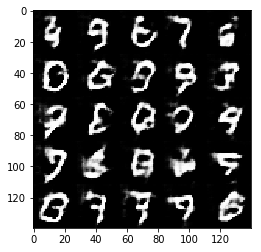

Epoch 1/2 Step 510... Discriminator Loss: 1.2262... Generator Loss: 1.2169
Epoch 1/2 Step 520... Discriminator Loss: 1.1497... Generator Loss: 0.9921
Epoch 1/2 Step 530... Discriminator Loss: 1.1444... Generator Loss: 1.0058
Epoch 1/2 Step 540... Discriminator Loss: 1.2214... Generator Loss: 0.9309
Epoch 1/2 Step 550... Discriminator Loss: 1.2792... Generator Loss: 0.6678
Epoch 1/2 Step 560... Discriminator Loss: 1.3722... Generator Loss: 0.7889
Epoch 1/2 Step 570... Discriminator Loss: 1.2188... Generator Loss: 1.0783
Epoch 1/2 Step 580... Discriminator Loss: 1.2117... Generator Loss: 0.9547
Epoch 1/2 Step 590... Discriminator Loss: 1.1225... Generator Loss: 0.9609
Epoch 1/2 Step 600... Discriminator Loss: 1.1990... Generator Loss: 0.7496


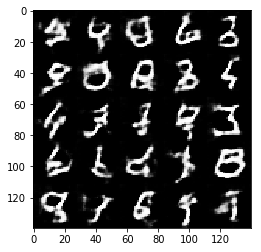

Epoch 1/2 Step 610... Discriminator Loss: 1.2758... Generator Loss: 0.9267
Epoch 1/2 Step 620... Discriminator Loss: 1.2094... Generator Loss: 0.9606
Epoch 1/2 Step 630... Discriminator Loss: 1.2776... Generator Loss: 1.3083
Epoch 1/2 Step 640... Discriminator Loss: 1.2613... Generator Loss: 0.8138
Epoch 1/2 Step 650... Discriminator Loss: 1.3467... Generator Loss: 0.5796
Epoch 1/2 Step 660... Discriminator Loss: 1.2294... Generator Loss: 1.0373
Epoch 1/2 Step 670... Discriminator Loss: 1.1800... Generator Loss: 1.1601
Epoch 1/2 Step 680... Discriminator Loss: 1.2778... Generator Loss: 0.7601
Epoch 1/2 Step 690... Discriminator Loss: 1.3179... Generator Loss: 0.7032
Epoch 1/2 Step 700... Discriminator Loss: 1.2209... Generator Loss: 1.0794


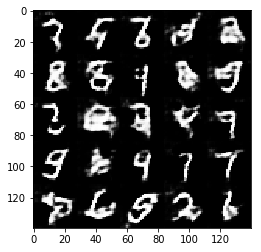

Epoch 1/2 Step 710... Discriminator Loss: 1.2053... Generator Loss: 0.8650
Epoch 1/2 Step 720... Discriminator Loss: 1.2135... Generator Loss: 0.8557
Epoch 1/2 Step 730... Discriminator Loss: 1.1726... Generator Loss: 0.9333
Epoch 1/2 Step 740... Discriminator Loss: 1.1828... Generator Loss: 0.7652
Epoch 1/2 Step 750... Discriminator Loss: 1.1635... Generator Loss: 0.8336
Epoch 1/2 Step 760... Discriminator Loss: 1.1310... Generator Loss: 0.9914
Epoch 1/2 Step 770... Discriminator Loss: 1.2161... Generator Loss: 1.4888
Epoch 1/2 Step 780... Discriminator Loss: 1.2623... Generator Loss: 0.8899
Epoch 1/2 Step 790... Discriminator Loss: 1.2805... Generator Loss: 0.9859
Epoch 1/2 Step 800... Discriminator Loss: 1.1665... Generator Loss: 1.0751


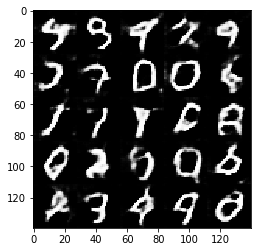

Epoch 1/2 Step 810... Discriminator Loss: 1.1225... Generator Loss: 1.1505
Epoch 1/2 Step 820... Discriminator Loss: 1.1261... Generator Loss: 1.0655
Epoch 1/2 Step 830... Discriminator Loss: 1.1978... Generator Loss: 0.8748
Epoch 1/2 Step 840... Discriminator Loss: 1.2665... Generator Loss: 1.1798
Epoch 1/2 Step 850... Discriminator Loss: 1.3685... Generator Loss: 1.1374
Epoch 1/2 Step 860... Discriminator Loss: 1.1890... Generator Loss: 0.7967
Epoch 1/2 Step 870... Discriminator Loss: 1.1773... Generator Loss: 0.9456
Epoch 1/2 Step 880... Discriminator Loss: 1.2516... Generator Loss: 0.9153
Epoch 1/2 Step 890... Discriminator Loss: 1.1830... Generator Loss: 0.9350
Epoch 1/2 Step 900... Discriminator Loss: 1.2086... Generator Loss: 1.0264


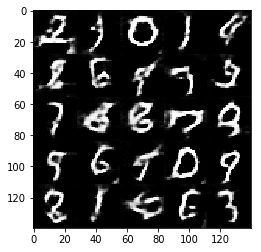

Epoch 1/2 Step 910... Discriminator Loss: 1.2736... Generator Loss: 0.7097
Epoch 1/2 Step 920... Discriminator Loss: 1.2202... Generator Loss: 0.9188
Epoch 1/2 Step 930... Discriminator Loss: 1.2120... Generator Loss: 0.8863
Epoch 1/2 Step 940... Discriminator Loss: 1.2833... Generator Loss: 0.7681
Epoch 1/2 Step 950... Discriminator Loss: 1.1438... Generator Loss: 0.9598
Epoch 1/2 Step 960... Discriminator Loss: 1.2649... Generator Loss: 1.4363
Epoch 1/2 Step 970... Discriminator Loss: 1.2305... Generator Loss: 0.9902
Epoch 1/2 Step 980... Discriminator Loss: 1.1817... Generator Loss: 0.9079
Epoch 1/2 Step 990... Discriminator Loss: 1.1330... Generator Loss: 1.0174
Epoch 1/2 Step 1000... Discriminator Loss: 1.0893... Generator Loss: 1.0899


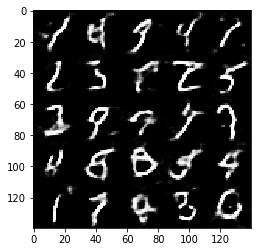

Epoch 1/2 Step 1010... Discriminator Loss: 1.1527... Generator Loss: 1.0704
Epoch 1/2 Step 1020... Discriminator Loss: 1.1230... Generator Loss: 0.9316
Epoch 1/2 Step 1030... Discriminator Loss: 1.4617... Generator Loss: 0.4557
Epoch 1/2 Step 1040... Discriminator Loss: 1.2066... Generator Loss: 0.8764
Epoch 1/2 Step 1050... Discriminator Loss: 1.2103... Generator Loss: 0.8292
Epoch 1/2 Step 1060... Discriminator Loss: 1.1300... Generator Loss: 1.2394
Epoch 1/2 Step 1070... Discriminator Loss: 1.4616... Generator Loss: 1.9046
Epoch 1/2 Step 1080... Discriminator Loss: 1.2228... Generator Loss: 0.7902
Epoch 1/2 Step 1090... Discriminator Loss: 1.0827... Generator Loss: 1.0587
Epoch 1/2 Step 1100... Discriminator Loss: 1.1715... Generator Loss: 0.7922


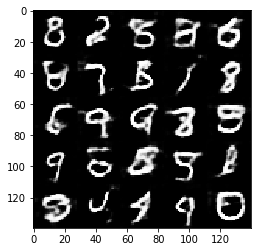

Epoch 1/2 Step 1110... Discriminator Loss: 1.1539... Generator Loss: 0.9181
Epoch 1/2 Step 1120... Discriminator Loss: 1.3453... Generator Loss: 1.7832
Epoch 1/2 Step 1130... Discriminator Loss: 1.1438... Generator Loss: 0.9693
Epoch 1/2 Step 1140... Discriminator Loss: 1.1341... Generator Loss: 1.3063
Epoch 1/2 Step 1150... Discriminator Loss: 1.1522... Generator Loss: 0.9219
Epoch 1/2 Step 1160... Discriminator Loss: 1.2876... Generator Loss: 0.6371
Epoch 1/2 Step 1170... Discriminator Loss: 1.1799... Generator Loss: 0.9208
Epoch 1/2 Step 1180... Discriminator Loss: 1.1228... Generator Loss: 1.4304
Epoch 1/2 Step 1190... Discriminator Loss: 1.0927... Generator Loss: 1.2261
Epoch 1/2 Step 1200... Discriminator Loss: 1.1369... Generator Loss: 0.9691


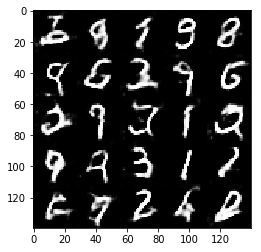

Epoch 1/2 Step 1210... Discriminator Loss: 1.0818... Generator Loss: 0.9091
Epoch 1/2 Step 1220... Discriminator Loss: 1.1418... Generator Loss: 0.8981
Epoch 1/2 Step 1230... Discriminator Loss: 1.2090... Generator Loss: 0.6756
Epoch 1/2 Step 1240... Discriminator Loss: 1.1894... Generator Loss: 0.7449
Epoch 1/2 Step 1250... Discriminator Loss: 1.0502... Generator Loss: 1.1656
Epoch 1/2 Step 1260... Discriminator Loss: 1.2842... Generator Loss: 1.1292
Epoch 1/2 Step 1270... Discriminator Loss: 1.1294... Generator Loss: 1.0026
Epoch 1/2 Step 1280... Discriminator Loss: 1.0353... Generator Loss: 1.3368
Epoch 1/2 Step 1290... Discriminator Loss: 1.1455... Generator Loss: 1.1371
Epoch 1/2 Step 1300... Discriminator Loss: 1.0992... Generator Loss: 0.8284


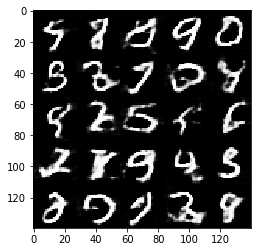

Epoch 1/2 Step 1310... Discriminator Loss: 1.2004... Generator Loss: 1.2099
Epoch 1/2 Step 1320... Discriminator Loss: 1.0749... Generator Loss: 1.0463
Epoch 1/2 Step 1330... Discriminator Loss: 1.0184... Generator Loss: 1.0609
Epoch 1/2 Step 1340... Discriminator Loss: 1.0458... Generator Loss: 0.8947
Epoch 1/2 Step 1350... Discriminator Loss: 1.1133... Generator Loss: 1.2691
Epoch 1/2 Step 1360... Discriminator Loss: 1.0233... Generator Loss: 0.9473
Epoch 1/2 Step 1370... Discriminator Loss: 1.0918... Generator Loss: 1.1497
Epoch 1/2 Step 1380... Discriminator Loss: 1.0495... Generator Loss: 1.0746
Epoch 1/2 Step 1390... Discriminator Loss: 1.0895... Generator Loss: 0.9933
Epoch 1/2 Step 1400... Discriminator Loss: 1.1587... Generator Loss: 1.6409


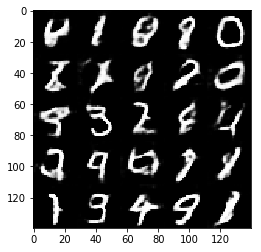

Epoch 1/2 Step 1410... Discriminator Loss: 1.0212... Generator Loss: 1.1750
Epoch 1/2 Step 1420... Discriminator Loss: 1.1769... Generator Loss: 0.5779
Epoch 1/2 Step 1430... Discriminator Loss: 1.0534... Generator Loss: 1.4635
Epoch 1/2 Step 1440... Discriminator Loss: 1.0842... Generator Loss: 0.9830
Epoch 1/2 Step 1450... Discriminator Loss: 1.1614... Generator Loss: 0.8067
Epoch 1/2 Step 1460... Discriminator Loss: 1.1024... Generator Loss: 0.9933
Epoch 1/2 Step 1470... Discriminator Loss: 1.0246... Generator Loss: 1.0890
Epoch 1/2 Step 1480... Discriminator Loss: 1.1490... Generator Loss: 0.7946
Epoch 1/2 Step 1490... Discriminator Loss: 1.0312... Generator Loss: 1.1368
Epoch 1/2 Step 1500... Discriminator Loss: 1.0393... Generator Loss: 1.4345


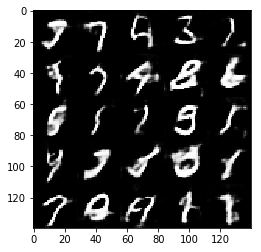

Epoch 1/2 Step 1510... Discriminator Loss: 1.0489... Generator Loss: 1.1294
Epoch 1/2 Step 1520... Discriminator Loss: 1.1590... Generator Loss: 0.7882
Epoch 1/2 Step 1530... Discriminator Loss: 1.1797... Generator Loss: 0.7908
Epoch 1/2 Step 1540... Discriminator Loss: 0.9389... Generator Loss: 1.1265
Epoch 1/2 Step 1550... Discriminator Loss: 1.0092... Generator Loss: 1.1202
Epoch 1/2 Step 1560... Discriminator Loss: 1.0520... Generator Loss: 0.8515
Epoch 1/2 Step 1570... Discriminator Loss: 1.0764... Generator Loss: 1.0491
Epoch 1/2 Step 1580... Discriminator Loss: 1.0683... Generator Loss: 1.1037
Epoch 1/2 Step 1590... Discriminator Loss: 1.1025... Generator Loss: 1.3191
Epoch 1/2 Step 1600... Discriminator Loss: 1.0948... Generator Loss: 0.9767


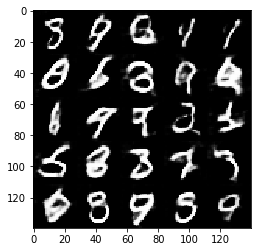

Epoch 1/2 Step 1610... Discriminator Loss: 1.1329... Generator Loss: 1.0522
Epoch 1/2 Step 1620... Discriminator Loss: 1.1121... Generator Loss: 1.3763
Epoch 1/2 Step 1630... Discriminator Loss: 0.9848... Generator Loss: 1.1208
Epoch 1/2 Step 1640... Discriminator Loss: 0.9402... Generator Loss: 1.2292
Epoch 1/2 Step 1650... Discriminator Loss: 1.1450... Generator Loss: 1.3114
Epoch 1/2 Step 1660... Discriminator Loss: 0.9340... Generator Loss: 1.0853
Epoch 2/2 Step 1670... Discriminator Loss: 1.0966... Generator Loss: 0.7668
Epoch 2/2 Step 1680... Discriminator Loss: 1.0368... Generator Loss: 1.3376
Epoch 2/2 Step 1690... Discriminator Loss: 1.2214... Generator Loss: 0.6749
Epoch 2/2 Step 1700... Discriminator Loss: 0.9536... Generator Loss: 1.6628


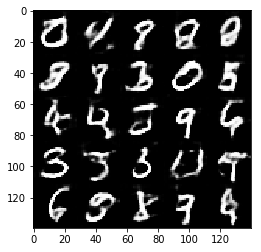

Epoch 2/2 Step 1710... Discriminator Loss: 0.9670... Generator Loss: 1.0493
Epoch 2/2 Step 1720... Discriminator Loss: 0.9657... Generator Loss: 1.5275
Epoch 2/2 Step 1730... Discriminator Loss: 1.0820... Generator Loss: 0.9926
Epoch 2/2 Step 1740... Discriminator Loss: 1.0666... Generator Loss: 1.2974
Epoch 2/2 Step 1750... Discriminator Loss: 0.9859... Generator Loss: 1.2401
Epoch 2/2 Step 1760... Discriminator Loss: 1.0186... Generator Loss: 0.8982
Epoch 2/2 Step 1770... Discriminator Loss: 1.3041... Generator Loss: 0.5631
Epoch 2/2 Step 1780... Discriminator Loss: 0.9870... Generator Loss: 1.2001
Epoch 2/2 Step 1790... Discriminator Loss: 1.1136... Generator Loss: 1.5101
Epoch 2/2 Step 1800... Discriminator Loss: 1.0583... Generator Loss: 0.9896


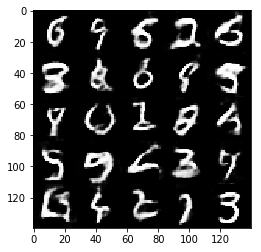

Epoch 2/2 Step 1810... Discriminator Loss: 1.0256... Generator Loss: 0.9932
Epoch 2/2 Step 1820... Discriminator Loss: 1.1517... Generator Loss: 0.8480
Epoch 2/2 Step 1830... Discriminator Loss: 0.9882... Generator Loss: 1.3288
Epoch 2/2 Step 1840... Discriminator Loss: 1.0751... Generator Loss: 2.0456
Epoch 2/2 Step 1850... Discriminator Loss: 0.9966... Generator Loss: 1.2511
Epoch 2/2 Step 1860... Discriminator Loss: 1.0842... Generator Loss: 1.0407
Epoch 2/2 Step 1870... Discriminator Loss: 1.0621... Generator Loss: 0.8678
Epoch 2/2 Step 1880... Discriminator Loss: 1.1155... Generator Loss: 1.6556
Epoch 2/2 Step 1890... Discriminator Loss: 1.0526... Generator Loss: 0.9310
Epoch 2/2 Step 1900... Discriminator Loss: 0.9742... Generator Loss: 1.1815


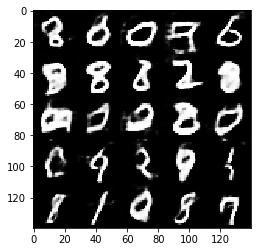

Epoch 2/2 Step 1910... Discriminator Loss: 1.0799... Generator Loss: 1.8546
Epoch 2/2 Step 1920... Discriminator Loss: 1.0145... Generator Loss: 1.4120
Epoch 2/2 Step 1930... Discriminator Loss: 1.1587... Generator Loss: 1.7203
Epoch 2/2 Step 1940... Discriminator Loss: 0.9111... Generator Loss: 1.6151
Epoch 2/2 Step 1950... Discriminator Loss: 1.1325... Generator Loss: 0.7677
Epoch 2/2 Step 1960... Discriminator Loss: 1.0466... Generator Loss: 0.9598
Epoch 2/2 Step 1970... Discriminator Loss: 0.9935... Generator Loss: 1.0925
Epoch 2/2 Step 1980... Discriminator Loss: 0.9661... Generator Loss: 1.0881
Epoch 2/2 Step 1990... Discriminator Loss: 1.0988... Generator Loss: 0.8215
Epoch 2/2 Step 2000... Discriminator Loss: 1.0469... Generator Loss: 1.0409


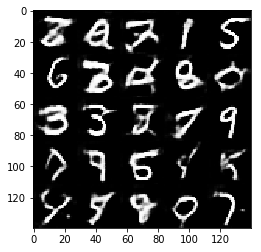

Epoch 2/2 Step 2010... Discriminator Loss: 1.0334... Generator Loss: 0.9046
Epoch 2/2 Step 2020... Discriminator Loss: 0.9791... Generator Loss: 1.3983
Epoch 2/2 Step 2030... Discriminator Loss: 1.0505... Generator Loss: 0.9285
Epoch 2/2 Step 2040... Discriminator Loss: 1.0019... Generator Loss: 1.4910
Epoch 2/2 Step 2050... Discriminator Loss: 1.0382... Generator Loss: 1.0746
Epoch 2/2 Step 2060... Discriminator Loss: 0.9882... Generator Loss: 1.0518
Epoch 2/2 Step 2070... Discriminator Loss: 1.0405... Generator Loss: 1.0396
Epoch 2/2 Step 2080... Discriminator Loss: 0.9601... Generator Loss: 1.9255
Epoch 2/2 Step 2090... Discriminator Loss: 0.9655... Generator Loss: 1.3642
Epoch 2/2 Step 2100... Discriminator Loss: 1.0988... Generator Loss: 2.1685


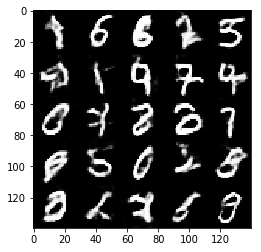

Epoch 2/2 Step 2110... Discriminator Loss: 0.9992... Generator Loss: 1.0179
Epoch 2/2 Step 2120... Discriminator Loss: 1.0121... Generator Loss: 0.9641
Epoch 2/2 Step 2130... Discriminator Loss: 0.9756... Generator Loss: 1.2632
Epoch 2/2 Step 2140... Discriminator Loss: 1.0825... Generator Loss: 1.8475
Epoch 2/2 Step 2150... Discriminator Loss: 1.0501... Generator Loss: 1.3723
Epoch 2/2 Step 2160... Discriminator Loss: 1.0664... Generator Loss: 1.5608
Epoch 2/2 Step 2170... Discriminator Loss: 1.0437... Generator Loss: 0.8856
Epoch 2/2 Step 2180... Discriminator Loss: 0.9053... Generator Loss: 1.6547
Epoch 2/2 Step 2190... Discriminator Loss: 0.9554... Generator Loss: 1.3528
Epoch 2/2 Step 2200... Discriminator Loss: 1.1640... Generator Loss: 0.7085


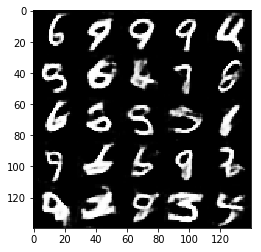

Epoch 2/2 Step 2210... Discriminator Loss: 0.9386... Generator Loss: 1.5209
Epoch 2/2 Step 2220... Discriminator Loss: 0.9754... Generator Loss: 0.9843
Epoch 2/2 Step 2230... Discriminator Loss: 0.9205... Generator Loss: 1.3321
Epoch 2/2 Step 2240... Discriminator Loss: 1.0651... Generator Loss: 1.8948
Epoch 2/2 Step 2250... Discriminator Loss: 0.9564... Generator Loss: 0.9701
Epoch 2/2 Step 2260... Discriminator Loss: 0.8666... Generator Loss: 1.6225
Epoch 2/2 Step 2270... Discriminator Loss: 0.8463... Generator Loss: 1.7063
Epoch 2/2 Step 2280... Discriminator Loss: 0.9362... Generator Loss: 1.2748
Epoch 2/2 Step 2290... Discriminator Loss: 0.9106... Generator Loss: 1.3503
Epoch 2/2 Step 2300... Discriminator Loss: 1.2222... Generator Loss: 0.6263


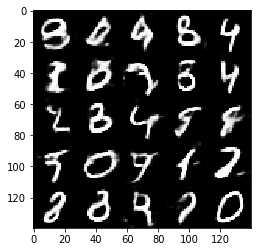

Epoch 2/2 Step 2310... Discriminator Loss: 0.9149... Generator Loss: 1.3243
Epoch 2/2 Step 2320... Discriminator Loss: 0.9100... Generator Loss: 1.5300
Epoch 2/2 Step 2330... Discriminator Loss: 1.1609... Generator Loss: 0.8221
Epoch 2/2 Step 2340... Discriminator Loss: 0.8600... Generator Loss: 1.3023
Epoch 2/2 Step 2350... Discriminator Loss: 0.9102... Generator Loss: 1.1224
Epoch 2/2 Step 2360... Discriminator Loss: 0.9318... Generator Loss: 1.6405
Epoch 2/2 Step 2370... Discriminator Loss: 0.8379... Generator Loss: 1.8234
Epoch 2/2 Step 2380... Discriminator Loss: 0.9157... Generator Loss: 1.0532
Epoch 2/2 Step 2390... Discriminator Loss: 1.0488... Generator Loss: 1.0112
Epoch 2/2 Step 2400... Discriminator Loss: 1.0298... Generator Loss: 0.8893


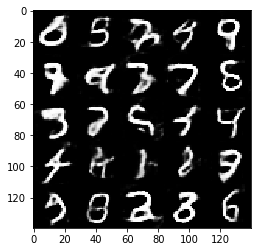

Epoch 2/2 Step 2410... Discriminator Loss: 0.9707... Generator Loss: 1.1874
Epoch 2/2 Step 2420... Discriminator Loss: 0.9689... Generator Loss: 1.2121
Epoch 2/2 Step 2430... Discriminator Loss: 1.3968... Generator Loss: 2.5197
Epoch 2/2 Step 2440... Discriminator Loss: 0.9542... Generator Loss: 1.2511
Epoch 2/2 Step 2450... Discriminator Loss: 0.9902... Generator Loss: 1.1047
Epoch 2/2 Step 2460... Discriminator Loss: 1.0429... Generator Loss: 0.8889
Epoch 2/2 Step 2470... Discriminator Loss: 1.1203... Generator Loss: 0.8071
Epoch 2/2 Step 2480... Discriminator Loss: 0.9226... Generator Loss: 1.5347
Epoch 2/2 Step 2490... Discriminator Loss: 1.2496... Generator Loss: 2.5203
Epoch 2/2 Step 2500... Discriminator Loss: 1.0278... Generator Loss: 0.9496


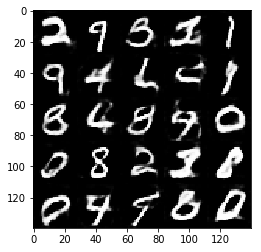

Epoch 2/2 Step 2510... Discriminator Loss: 1.0361... Generator Loss: 1.6842
Epoch 2/2 Step 2520... Discriminator Loss: 0.8215... Generator Loss: 1.3559
Epoch 2/2 Step 2530... Discriminator Loss: 0.9740... Generator Loss: 1.1228
Epoch 2/2 Step 2540... Discriminator Loss: 0.8846... Generator Loss: 1.5035
Epoch 2/2 Step 2550... Discriminator Loss: 1.0115... Generator Loss: 1.6667
Epoch 2/2 Step 2560... Discriminator Loss: 0.9966... Generator Loss: 1.6143
Epoch 2/2 Step 2570... Discriminator Loss: 1.0902... Generator Loss: 1.5338
Epoch 2/2 Step 2580... Discriminator Loss: 0.9152... Generator Loss: 1.1539
Epoch 2/2 Step 2590... Discriminator Loss: 0.9503... Generator Loss: 1.2785
Epoch 2/2 Step 2600... Discriminator Loss: 0.9577... Generator Loss: 1.0403


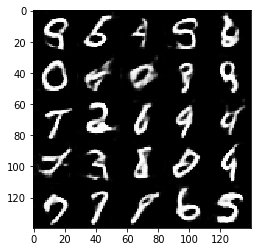

Epoch 2/2 Step 2610... Discriminator Loss: 0.9790... Generator Loss: 1.0501
Epoch 2/2 Step 2620... Discriminator Loss: 1.1142... Generator Loss: 1.9274
Epoch 2/2 Step 2630... Discriminator Loss: 0.9387... Generator Loss: 1.3150
Epoch 2/2 Step 2640... Discriminator Loss: 0.8821... Generator Loss: 1.4177
Epoch 2/2 Step 2650... Discriminator Loss: 1.0721... Generator Loss: 0.9011
Epoch 2/2 Step 2660... Discriminator Loss: 0.9637... Generator Loss: 1.5100
Epoch 2/2 Step 2670... Discriminator Loss: 0.8803... Generator Loss: 1.9566
Epoch 2/2 Step 2680... Discriminator Loss: 0.9525... Generator Loss: 2.2748
Epoch 2/2 Step 2690... Discriminator Loss: 0.8835... Generator Loss: 1.3337
Epoch 2/2 Step 2700... Discriminator Loss: 0.7960... Generator Loss: 1.3827


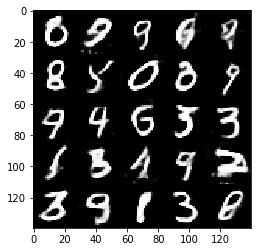

Epoch 2/2 Step 2710... Discriminator Loss: 0.8552... Generator Loss: 1.3376
Epoch 2/2 Step 2720... Discriminator Loss: 0.9828... Generator Loss: 1.0743
Epoch 2/2 Step 2730... Discriminator Loss: 0.7850... Generator Loss: 1.4850
Epoch 2/2 Step 2740... Discriminator Loss: 1.1776... Generator Loss: 0.7786
Epoch 2/2 Step 2750... Discriminator Loss: 0.9546... Generator Loss: 1.4664
Epoch 2/2 Step 2760... Discriminator Loss: 0.8806... Generator Loss: 1.2670
Epoch 2/2 Step 2770... Discriminator Loss: 0.9892... Generator Loss: 0.9836
Epoch 2/2 Step 2780... Discriminator Loss: 0.8666... Generator Loss: 1.9616
Epoch 2/2 Step 2790... Discriminator Loss: 1.2216... Generator Loss: 0.6839
Epoch 2/2 Step 2800... Discriminator Loss: 0.8884... Generator Loss: 1.6699


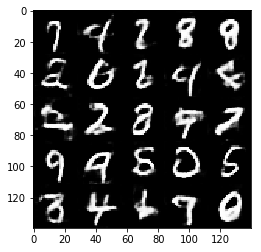

Epoch 2/2 Step 2810... Discriminator Loss: 0.8651... Generator Loss: 1.1419
Epoch 2/2 Step 2820... Discriminator Loss: 0.9045... Generator Loss: 1.2047
Epoch 2/2 Step 2830... Discriminator Loss: 0.9670... Generator Loss: 0.9906
Epoch 2/2 Step 2840... Discriminator Loss: 0.9277... Generator Loss: 1.7886
Epoch 2/2 Step 2850... Discriminator Loss: 0.8652... Generator Loss: 1.9342
Epoch 2/2 Step 2860... Discriminator Loss: 0.7860... Generator Loss: 1.4260
Epoch 2/2 Step 2870... Discriminator Loss: 0.8438... Generator Loss: 1.5113
Epoch 2/2 Step 2880... Discriminator Loss: 0.8000... Generator Loss: 1.6835
Epoch 2/2 Step 2890... Discriminator Loss: 0.8603... Generator Loss: 2.0548
Epoch 2/2 Step 2900... Discriminator Loss: 0.8823... Generator Loss: 1.9656


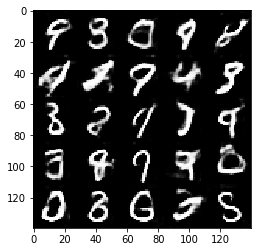

Epoch 2/2 Step 2910... Discriminator Loss: 0.9602... Generator Loss: 1.2054
Epoch 2/2 Step 2920... Discriminator Loss: 0.9181... Generator Loss: 1.7120
Epoch 2/2 Step 2930... Discriminator Loss: 0.8934... Generator Loss: 1.4815
Epoch 2/2 Step 2940... Discriminator Loss: 0.9179... Generator Loss: 1.1334
Epoch 2/2 Step 2950... Discriminator Loss: 0.9508... Generator Loss: 2.1913
Epoch 2/2 Step 2960... Discriminator Loss: 0.9072... Generator Loss: 1.2413
Epoch 2/2 Step 2970... Discriminator Loss: 0.7345... Generator Loss: 1.8412
Epoch 2/2 Step 2980... Discriminator Loss: 0.8942... Generator Loss: 1.5739
Epoch 2/2 Step 2990... Discriminator Loss: 0.7901... Generator Loss: 1.4964
Epoch 2/2 Step 3000... Discriminator Loss: 0.8196... Generator Loss: 1.7234


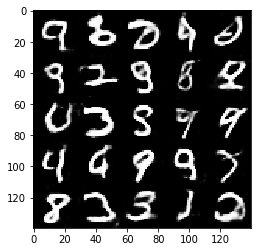

Epoch 2/2 Step 3010... Discriminator Loss: 0.9847... Generator Loss: 1.2385
Epoch 2/2 Step 3020... Discriminator Loss: 0.8346... Generator Loss: 1.1446
Epoch 2/2 Step 3030... Discriminator Loss: 0.7690... Generator Loss: 1.5271
Epoch 2/2 Step 3040... Discriminator Loss: 1.0917... Generator Loss: 1.0538
Epoch 2/2 Step 3050... Discriminator Loss: 0.8902... Generator Loss: 1.2101
Epoch 2/2 Step 3060... Discriminator Loss: 0.8470... Generator Loss: 1.3777
Epoch 2/2 Step 3070... Discriminator Loss: 0.9189... Generator Loss: 1.7604
Epoch 2/2 Step 3080... Discriminator Loss: 0.8722... Generator Loss: 2.0258
Epoch 2/2 Step 3090... Discriminator Loss: 0.9045... Generator Loss: 1.2338
Epoch 2/2 Step 3100... Discriminator Loss: 1.0451... Generator Loss: 0.9370


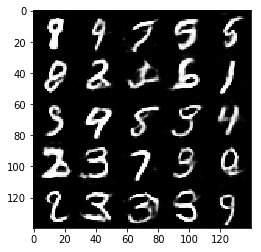

Epoch 2/2 Step 3110... Discriminator Loss: 0.9535... Generator Loss: 1.0484
Epoch 2/2 Step 3120... Discriminator Loss: 0.7747... Generator Loss: 1.3357
Epoch 2/2 Step 3130... Discriminator Loss: 1.1742... Generator Loss: 0.6633
Epoch 2/2 Step 3140... Discriminator Loss: 0.8267... Generator Loss: 1.9204
Epoch 2/2 Step 3150... Discriminator Loss: 0.8213... Generator Loss: 1.4182
Epoch 2/2 Step 3160... Discriminator Loss: 0.8394... Generator Loss: 1.2940
Epoch 2/2 Step 3170... Discriminator Loss: 0.8973... Generator Loss: 1.1633
Epoch 2/2 Step 3180... Discriminator Loss: 0.8114... Generator Loss: 1.3977
Epoch 2/2 Step 3190... Discriminator Loss: 0.9819... Generator Loss: 1.6884
Epoch 2/2 Step 3200... Discriminator Loss: 0.9100... Generator Loss: 1.1437


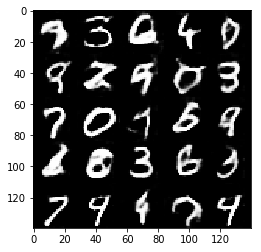

Epoch 2/2 Step 3210... Discriminator Loss: 0.9569... Generator Loss: 0.9430
Epoch 2/2 Step 3220... Discriminator Loss: 0.9735... Generator Loss: 2.5167
Epoch 2/2 Step 3230... Discriminator Loss: 0.8775... Generator Loss: 1.1991
Epoch 2/2 Step 3240... Discriminator Loss: 0.7484... Generator Loss: 1.5461
Epoch 2/2 Step 3250... Discriminator Loss: 0.8814... Generator Loss: 1.2751
Epoch 2/2 Step 3260... Discriminator Loss: 0.8701... Generator Loss: 1.3335
Epoch 2/2 Step 3270... Discriminator Loss: 0.8904... Generator Loss: 1.6429
Epoch 2/2 Step 3280... Discriminator Loss: 0.8431... Generator Loss: 1.4158
Epoch 2/2 Step 3290... Discriminator Loss: 0.9054... Generator Loss: 1.0871
Epoch 2/2 Step 3300... Discriminator Loss: 0.7981... Generator Loss: 1.8841


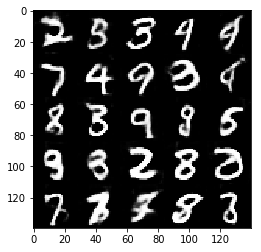

Epoch 2/2 Step 3310... Discriminator Loss: 0.7770... Generator Loss: 1.6252
Epoch 2/2 Step 3320... Discriminator Loss: 1.6263... Generator Loss: 0.4550
Epoch 2/2 Step 3330... Discriminator Loss: 0.8521... Generator Loss: 1.5321


In [13]:
batch_size = 36
z_dim = 100
learning_rate = 0.00025
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Step 10... Discriminator Loss: 1.1178... Generator Loss: 1.0024
Epoch 1/1 Step 20... Discriminator Loss: 1.1437... Generator Loss: 0.8603
Epoch 1/1 Step 30... Discriminator Loss: 1.0006... Generator Loss: 1.0454
Epoch 1/1 Step 40... Discriminator Loss: 1.1162... Generator Loss: 0.7473
Epoch 1/1 Step 50... Discriminator Loss: 0.8108... Generator Loss: 1.3153
Epoch 1/1 Step 60... Discriminator Loss: 1.1114... Generator Loss: 1.4401
Epoch 1/1 Step 70... Discriminator Loss: 1.0341... Generator Loss: 2.1647
Epoch 1/1 Step 80... Discriminator Loss: 0.9273... Generator Loss: 1.9626
Epoch 1/1 Step 90... Discriminator Loss: 1.1978... Generator Loss: 1.1029
Epoch 1/1 Step 100... Discriminator Loss: 0.8598... Generator Loss: 1.6486


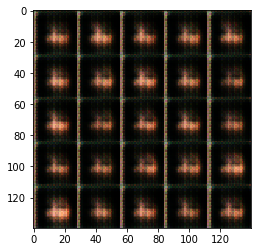

Epoch 1/1 Step 110... Discriminator Loss: 0.9642... Generator Loss: 0.8976
Epoch 1/1 Step 120... Discriminator Loss: 0.7209... Generator Loss: 2.1126
Epoch 1/1 Step 130... Discriminator Loss: 0.6065... Generator Loss: 1.5927
Epoch 1/1 Step 140... Discriminator Loss: 0.7246... Generator Loss: 1.6106
Epoch 1/1 Step 150... Discriminator Loss: 0.6772... Generator Loss: 1.7164
Epoch 1/1 Step 160... Discriminator Loss: 0.5650... Generator Loss: 2.0919
Epoch 1/1 Step 170... Discriminator Loss: 1.4063... Generator Loss: 0.4434
Epoch 1/1 Step 180... Discriminator Loss: 0.8217... Generator Loss: 1.5670
Epoch 1/1 Step 190... Discriminator Loss: 0.6926... Generator Loss: 1.5141
Epoch 1/1 Step 200... Discriminator Loss: 1.1319... Generator Loss: 0.9072


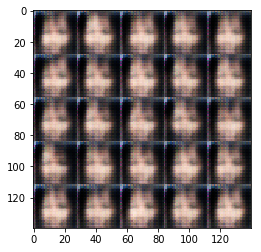

Epoch 1/1 Step 210... Discriminator Loss: 0.7133... Generator Loss: 1.6975
Epoch 1/1 Step 220... Discriminator Loss: 1.1294... Generator Loss: 1.1007
Epoch 1/1 Step 230... Discriminator Loss: 1.0748... Generator Loss: 1.1060
Epoch 1/1 Step 240... Discriminator Loss: 0.6908... Generator Loss: 1.7756
Epoch 1/1 Step 250... Discriminator Loss: 0.9748... Generator Loss: 1.4575
Epoch 1/1 Step 260... Discriminator Loss: 0.8032... Generator Loss: 1.5894
Epoch 1/1 Step 270... Discriminator Loss: 1.2179... Generator Loss: 2.7409
Epoch 1/1 Step 280... Discriminator Loss: 0.6184... Generator Loss: 1.9805
Epoch 1/1 Step 290... Discriminator Loss: 0.9039... Generator Loss: 1.1591
Epoch 1/1 Step 300... Discriminator Loss: 0.9426... Generator Loss: 1.0305


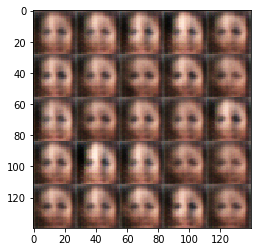

Epoch 1/1 Step 310... Discriminator Loss: 0.7204... Generator Loss: 1.6707
Epoch 1/1 Step 320... Discriminator Loss: 1.2425... Generator Loss: 1.3845
Epoch 1/1 Step 330... Discriminator Loss: 1.1514... Generator Loss: 1.0798
Epoch 1/1 Step 340... Discriminator Loss: 1.0419... Generator Loss: 1.0322
Epoch 1/1 Step 350... Discriminator Loss: 1.3451... Generator Loss: 0.7397
Epoch 1/1 Step 360... Discriminator Loss: 0.6906... Generator Loss: 1.5729
Epoch 1/1 Step 370... Discriminator Loss: 0.9928... Generator Loss: 1.0524
Epoch 1/1 Step 380... Discriminator Loss: 1.1848... Generator Loss: 0.8994
Epoch 1/1 Step 390... Discriminator Loss: 0.8632... Generator Loss: 1.7508
Epoch 1/1 Step 400... Discriminator Loss: 1.0497... Generator Loss: 1.7748


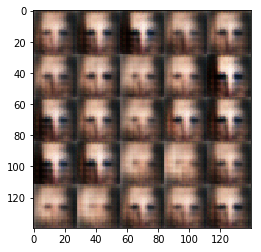

Epoch 1/1 Step 410... Discriminator Loss: 0.9758... Generator Loss: 1.0457
Epoch 1/1 Step 420... Discriminator Loss: 1.2483... Generator Loss: 0.8464
Epoch 1/1 Step 430... Discriminator Loss: 1.1906... Generator Loss: 0.8680
Epoch 1/1 Step 440... Discriminator Loss: 1.1871... Generator Loss: 0.8787
Epoch 1/1 Step 450... Discriminator Loss: 1.0663... Generator Loss: 1.0351
Epoch 1/1 Step 460... Discriminator Loss: 1.0283... Generator Loss: 1.1370
Epoch 1/1 Step 470... Discriminator Loss: 1.1406... Generator Loss: 0.9142
Epoch 1/1 Step 480... Discriminator Loss: 1.2283... Generator Loss: 0.9624
Epoch 1/1 Step 490... Discriminator Loss: 1.0612... Generator Loss: 1.3608
Epoch 1/1 Step 500... Discriminator Loss: 1.1392... Generator Loss: 0.9768


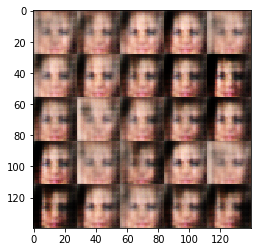

Epoch 1/1 Step 510... Discriminator Loss: 1.0314... Generator Loss: 1.1905
Epoch 1/1 Step 520... Discriminator Loss: 1.2793... Generator Loss: 0.9984
Epoch 1/1 Step 530... Discriminator Loss: 1.1669... Generator Loss: 0.9418
Epoch 1/1 Step 540... Discriminator Loss: 1.1114... Generator Loss: 0.9762
Epoch 1/1 Step 550... Discriminator Loss: 1.3212... Generator Loss: 1.1057
Epoch 1/1 Step 560... Discriminator Loss: 1.2639... Generator Loss: 0.6856
Epoch 1/1 Step 570... Discriminator Loss: 1.2028... Generator Loss: 0.9873
Epoch 1/1 Step 580... Discriminator Loss: 1.2465... Generator Loss: 1.0313
Epoch 1/1 Step 590... Discriminator Loss: 1.3012... Generator Loss: 1.0552
Epoch 1/1 Step 600... Discriminator Loss: 1.1440... Generator Loss: 1.1005


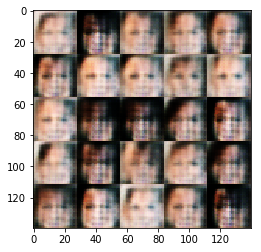

Epoch 1/1 Step 610... Discriminator Loss: 1.1394... Generator Loss: 0.9760
Epoch 1/1 Step 620... Discriminator Loss: 1.1125... Generator Loss: 0.9884
Epoch 1/1 Step 630... Discriminator Loss: 1.3336... Generator Loss: 0.6832
Epoch 1/1 Step 640... Discriminator Loss: 1.1937... Generator Loss: 0.9869
Epoch 1/1 Step 650... Discriminator Loss: 1.2933... Generator Loss: 0.8761
Epoch 1/1 Step 660... Discriminator Loss: 1.4680... Generator Loss: 0.6457
Epoch 1/1 Step 670... Discriminator Loss: 1.1982... Generator Loss: 1.0125
Epoch 1/1 Step 680... Discriminator Loss: 1.3196... Generator Loss: 1.1895
Epoch 1/1 Step 690... Discriminator Loss: 1.2128... Generator Loss: 1.0271
Epoch 1/1 Step 700... Discriminator Loss: 1.3367... Generator Loss: 0.7824


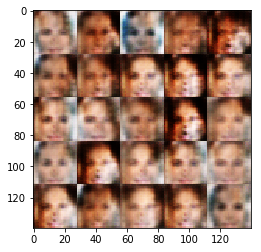

Epoch 1/1 Step 710... Discriminator Loss: 1.3631... Generator Loss: 0.8147
Epoch 1/1 Step 720... Discriminator Loss: 1.3044... Generator Loss: 0.8371
Epoch 1/1 Step 730... Discriminator Loss: 1.1897... Generator Loss: 0.9308
Epoch 1/1 Step 740... Discriminator Loss: 1.2498... Generator Loss: 0.9671
Epoch 1/1 Step 750... Discriminator Loss: 1.2980... Generator Loss: 0.7551
Epoch 1/1 Step 760... Discriminator Loss: 1.2188... Generator Loss: 0.8841
Epoch 1/1 Step 770... Discriminator Loss: 1.2270... Generator Loss: 0.9394
Epoch 1/1 Step 780... Discriminator Loss: 1.1481... Generator Loss: 0.8595
Epoch 1/1 Step 790... Discriminator Loss: 1.2102... Generator Loss: 0.8686
Epoch 1/1 Step 800... Discriminator Loss: 1.1574... Generator Loss: 1.1168


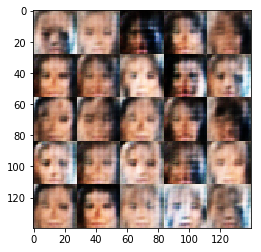

Epoch 1/1 Step 810... Discriminator Loss: 1.2281... Generator Loss: 0.9181
Epoch 1/1 Step 820... Discriminator Loss: 1.2317... Generator Loss: 0.9481
Epoch 1/1 Step 830... Discriminator Loss: 1.1920... Generator Loss: 1.0159
Epoch 1/1 Step 840... Discriminator Loss: 1.2397... Generator Loss: 0.9005
Epoch 1/1 Step 850... Discriminator Loss: 1.1725... Generator Loss: 0.9530
Epoch 1/1 Step 860... Discriminator Loss: 1.3178... Generator Loss: 1.1822
Epoch 1/1 Step 870... Discriminator Loss: 1.4290... Generator Loss: 0.6792
Epoch 1/1 Step 880... Discriminator Loss: 1.2226... Generator Loss: 1.0009
Epoch 1/1 Step 890... Discriminator Loss: 1.2369... Generator Loss: 0.8184
Epoch 1/1 Step 900... Discriminator Loss: 1.3154... Generator Loss: 0.7695


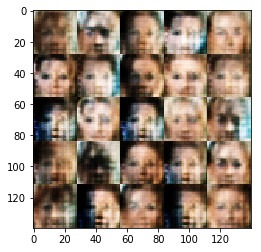

Epoch 1/1 Step 910... Discriminator Loss: 1.2541... Generator Loss: 0.9548
Epoch 1/1 Step 920... Discriminator Loss: 1.2845... Generator Loss: 0.8415
Epoch 1/1 Step 930... Discriminator Loss: 1.2682... Generator Loss: 0.8094
Epoch 1/1 Step 940... Discriminator Loss: 1.2461... Generator Loss: 0.8504
Epoch 1/1 Step 950... Discriminator Loss: 1.3227... Generator Loss: 0.7251
Epoch 1/1 Step 960... Discriminator Loss: 1.2433... Generator Loss: 0.8016
Epoch 1/1 Step 970... Discriminator Loss: 1.2623... Generator Loss: 0.8501
Epoch 1/1 Step 980... Discriminator Loss: 1.2607... Generator Loss: 0.7689
Epoch 1/1 Step 990... Discriminator Loss: 1.3073... Generator Loss: 0.8368
Epoch 1/1 Step 1000... Discriminator Loss: 1.2902... Generator Loss: 1.0993


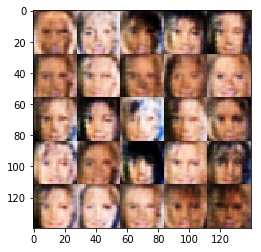

Epoch 1/1 Step 1010... Discriminator Loss: 1.2674... Generator Loss: 0.7912
Epoch 1/1 Step 1020... Discriminator Loss: 1.3519... Generator Loss: 0.8159
Epoch 1/1 Step 1030... Discriminator Loss: 1.2811... Generator Loss: 0.9300
Epoch 1/1 Step 1040... Discriminator Loss: 1.3365... Generator Loss: 0.8468
Epoch 1/1 Step 1050... Discriminator Loss: 1.3158... Generator Loss: 0.9022
Epoch 1/1 Step 1060... Discriminator Loss: 1.2668... Generator Loss: 0.8651
Epoch 1/1 Step 1070... Discriminator Loss: 1.2933... Generator Loss: 0.8386
Epoch 1/1 Step 1080... Discriminator Loss: 1.3155... Generator Loss: 0.8377
Epoch 1/1 Step 1090... Discriminator Loss: 1.3906... Generator Loss: 0.7458
Epoch 1/1 Step 1100... Discriminator Loss: 1.2841... Generator Loss: 0.9600


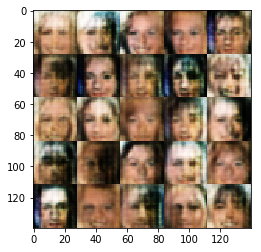

Epoch 1/1 Step 1110... Discriminator Loss: 1.2898... Generator Loss: 0.7993
Epoch 1/1 Step 1120... Discriminator Loss: 1.2790... Generator Loss: 0.7816
Epoch 1/1 Step 1130... Discriminator Loss: 1.3379... Generator Loss: 0.7771
Epoch 1/1 Step 1140... Discriminator Loss: 1.2560... Generator Loss: 0.8739
Epoch 1/1 Step 1150... Discriminator Loss: 1.3234... Generator Loss: 0.7791
Epoch 1/1 Step 1160... Discriminator Loss: 1.2896... Generator Loss: 0.8279
Epoch 1/1 Step 1170... Discriminator Loss: 1.3259... Generator Loss: 0.8688
Epoch 1/1 Step 1180... Discriminator Loss: 1.3188... Generator Loss: 0.8732
Epoch 1/1 Step 1190... Discriminator Loss: 1.2991... Generator Loss: 0.8816
Epoch 1/1 Step 1200... Discriminator Loss: 1.2541... Generator Loss: 0.8124


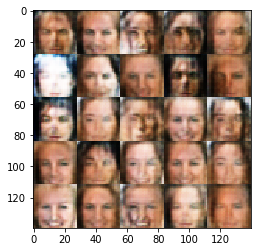

Epoch 1/1 Step 1210... Discriminator Loss: 1.3033... Generator Loss: 0.9123
Epoch 1/1 Step 1220... Discriminator Loss: 1.3024... Generator Loss: 0.8363
Epoch 1/1 Step 1230... Discriminator Loss: 1.3324... Generator Loss: 0.8423
Epoch 1/1 Step 1240... Discriminator Loss: 1.3344... Generator Loss: 0.7995
Epoch 1/1 Step 1250... Discriminator Loss: 1.2930... Generator Loss: 0.9852
Epoch 1/1 Step 1260... Discriminator Loss: 1.2937... Generator Loss: 0.7675
Epoch 1/1 Step 1270... Discriminator Loss: 1.3565... Generator Loss: 0.7921
Epoch 1/1 Step 1280... Discriminator Loss: 1.2902... Generator Loss: 0.8568
Epoch 1/1 Step 1290... Discriminator Loss: 1.2599... Generator Loss: 0.9919
Epoch 1/1 Step 1300... Discriminator Loss: 1.1877... Generator Loss: 0.8547


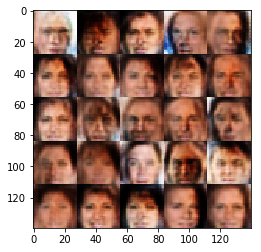

Epoch 1/1 Step 1310... Discriminator Loss: 1.2410... Generator Loss: 0.7648
Epoch 1/1 Step 1320... Discriminator Loss: 1.2258... Generator Loss: 0.9399
Epoch 1/1 Step 1330... Discriminator Loss: 1.2372... Generator Loss: 0.8377
Epoch 1/1 Step 1340... Discriminator Loss: 1.2908... Generator Loss: 0.8590
Epoch 1/1 Step 1350... Discriminator Loss: 1.3299... Generator Loss: 0.7766
Epoch 1/1 Step 1360... Discriminator Loss: 1.2964... Generator Loss: 0.8644
Epoch 1/1 Step 1370... Discriminator Loss: 1.3057... Generator Loss: 1.0183
Epoch 1/1 Step 1380... Discriminator Loss: 1.3291... Generator Loss: 0.7983
Epoch 1/1 Step 1390... Discriminator Loss: 1.2773... Generator Loss: 0.8889
Epoch 1/1 Step 1400... Discriminator Loss: 1.3546... Generator Loss: 0.7286


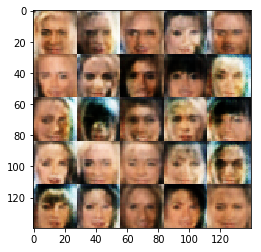

Epoch 1/1 Step 1410... Discriminator Loss: 1.3354... Generator Loss: 0.9882
Epoch 1/1 Step 1420... Discriminator Loss: 1.3022... Generator Loss: 0.9724
Epoch 1/1 Step 1430... Discriminator Loss: 1.3156... Generator Loss: 0.7720
Epoch 1/1 Step 1440... Discriminator Loss: 1.2153... Generator Loss: 1.0299
Epoch 1/1 Step 1450... Discriminator Loss: 1.2911... Generator Loss: 0.8606
Epoch 1/1 Step 1460... Discriminator Loss: 1.3245... Generator Loss: 0.7024
Epoch 1/1 Step 1470... Discriminator Loss: 1.3408... Generator Loss: 0.8536
Epoch 1/1 Step 1480... Discriminator Loss: 1.3108... Generator Loss: 0.9202
Epoch 1/1 Step 1490... Discriminator Loss: 1.2428... Generator Loss: 0.9399
Epoch 1/1 Step 1500... Discriminator Loss: 1.2766... Generator Loss: 0.9178


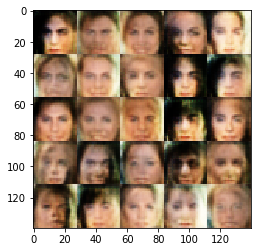

Epoch 1/1 Step 1510... Discriminator Loss: 1.2662... Generator Loss: 0.8601
Epoch 1/1 Step 1520... Discriminator Loss: 1.2753... Generator Loss: 0.8278
Epoch 1/1 Step 1530... Discriminator Loss: 1.2705... Generator Loss: 0.8994
Epoch 1/1 Step 1540... Discriminator Loss: 1.2540... Generator Loss: 0.8378
Epoch 1/1 Step 1550... Discriminator Loss: 1.3046... Generator Loss: 0.7820
Epoch 1/1 Step 1560... Discriminator Loss: 1.2243... Generator Loss: 0.7610
Epoch 1/1 Step 1570... Discriminator Loss: 1.2587... Generator Loss: 0.7860
Epoch 1/1 Step 1580... Discriminator Loss: 1.3045... Generator Loss: 0.8330
Epoch 1/1 Step 1590... Discriminator Loss: 1.3351... Generator Loss: 1.1244
Epoch 1/1 Step 1600... Discriminator Loss: 1.3346... Generator Loss: 0.8793


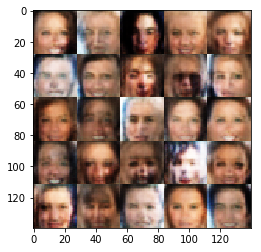

Epoch 1/1 Step 1610... Discriminator Loss: 1.2390... Generator Loss: 0.9115
Epoch 1/1 Step 1620... Discriminator Loss: 1.2513... Generator Loss: 0.8908
Epoch 1/1 Step 1630... Discriminator Loss: 1.3073... Generator Loss: 0.8914
Epoch 1/1 Step 1640... Discriminator Loss: 1.2937... Generator Loss: 0.8605
Epoch 1/1 Step 1650... Discriminator Loss: 1.2675... Generator Loss: 0.8189
Epoch 1/1 Step 1660... Discriminator Loss: 1.2723... Generator Loss: 0.8643
Epoch 1/1 Step 1670... Discriminator Loss: 1.2741... Generator Loss: 1.2037
Epoch 1/1 Step 1680... Discriminator Loss: 1.2499... Generator Loss: 0.9069
Epoch 1/1 Step 1690... Discriminator Loss: 1.2765... Generator Loss: 0.8885
Epoch 1/1 Step 1700... Discriminator Loss: 1.3931... Generator Loss: 0.6302


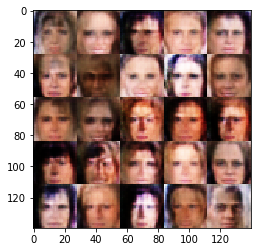

Epoch 1/1 Step 1710... Discriminator Loss: 1.2337... Generator Loss: 0.8033
Epoch 1/1 Step 1720... Discriminator Loss: 1.2336... Generator Loss: 0.8608
Epoch 1/1 Step 1730... Discriminator Loss: 1.2531... Generator Loss: 1.0007
Epoch 1/1 Step 1740... Discriminator Loss: 1.2707... Generator Loss: 0.8159
Epoch 1/1 Step 1750... Discriminator Loss: 1.2433... Generator Loss: 0.9049
Epoch 1/1 Step 1760... Discriminator Loss: 1.3650... Generator Loss: 0.7421
Epoch 1/1 Step 1770... Discriminator Loss: 1.2327... Generator Loss: 0.7197
Epoch 1/1 Step 1780... Discriminator Loss: 1.2750... Generator Loss: 0.9784
Epoch 1/1 Step 1790... Discriminator Loss: 1.2809... Generator Loss: 0.8697
Epoch 1/1 Step 1800... Discriminator Loss: 1.2745... Generator Loss: 0.8461


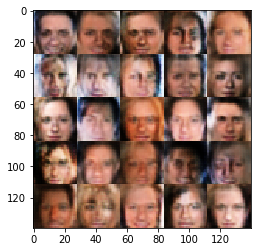

Epoch 1/1 Step 1810... Discriminator Loss: 1.2437... Generator Loss: 0.9119
Epoch 1/1 Step 1820... Discriminator Loss: 1.2638... Generator Loss: 0.8754
Epoch 1/1 Step 1830... Discriminator Loss: 1.2864... Generator Loss: 0.7666
Epoch 1/1 Step 1840... Discriminator Loss: 1.3228... Generator Loss: 0.7359
Epoch 1/1 Step 1850... Discriminator Loss: 1.4111... Generator Loss: 0.6833
Epoch 1/1 Step 1860... Discriminator Loss: 1.3302... Generator Loss: 0.9400
Epoch 1/1 Step 1870... Discriminator Loss: 1.2939... Generator Loss: 0.8550
Epoch 1/1 Step 1880... Discriminator Loss: 1.3011... Generator Loss: 0.9892
Epoch 1/1 Step 1890... Discriminator Loss: 1.2837... Generator Loss: 0.7806
Epoch 1/1 Step 1900... Discriminator Loss: 1.2970... Generator Loss: 0.8758


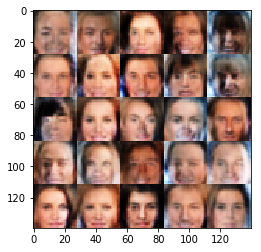

Epoch 1/1 Step 1910... Discriminator Loss: 1.2738... Generator Loss: 0.7819
Epoch 1/1 Step 1920... Discriminator Loss: 1.2420... Generator Loss: 0.7695
Epoch 1/1 Step 1930... Discriminator Loss: 1.2908... Generator Loss: 1.1033
Epoch 1/1 Step 1940... Discriminator Loss: 1.3323... Generator Loss: 0.7812
Epoch 1/1 Step 1950... Discriminator Loss: 1.3061... Generator Loss: 0.8672
Epoch 1/1 Step 1960... Discriminator Loss: 1.3802... Generator Loss: 0.7017
Epoch 1/1 Step 1970... Discriminator Loss: 1.3435... Generator Loss: 0.8594
Epoch 1/1 Step 1980... Discriminator Loss: 1.2265... Generator Loss: 0.9867
Epoch 1/1 Step 1990... Discriminator Loss: 1.2388... Generator Loss: 0.8542
Epoch 1/1 Step 2000... Discriminator Loss: 1.2895... Generator Loss: 0.8532


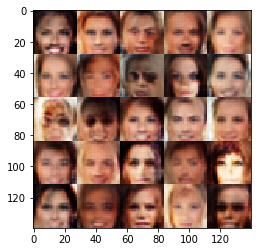

Epoch 1/1 Step 2010... Discriminator Loss: 1.2731... Generator Loss: 0.8118
Epoch 1/1 Step 2020... Discriminator Loss: 1.3145... Generator Loss: 0.7242
Epoch 1/1 Step 2030... Discriminator Loss: 1.3360... Generator Loss: 0.7866
Epoch 1/1 Step 2040... Discriminator Loss: 1.2864... Generator Loss: 0.8262
Epoch 1/1 Step 2050... Discriminator Loss: 1.2266... Generator Loss: 0.7927
Epoch 1/1 Step 2060... Discriminator Loss: 1.2647... Generator Loss: 1.0485
Epoch 1/1 Step 2070... Discriminator Loss: 1.2633... Generator Loss: 0.8305
Epoch 1/1 Step 2080... Discriminator Loss: 1.2367... Generator Loss: 0.9290
Epoch 1/1 Step 2090... Discriminator Loss: 1.2940... Generator Loss: 0.9367
Epoch 1/1 Step 2100... Discriminator Loss: 1.2406... Generator Loss: 0.8673


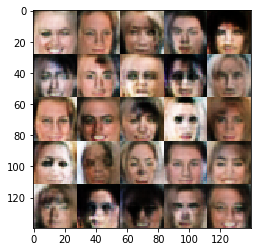

Epoch 1/1 Step 2110... Discriminator Loss: 1.2830... Generator Loss: 0.8492
Epoch 1/1 Step 2120... Discriminator Loss: 1.2814... Generator Loss: 0.8328
Epoch 1/1 Step 2130... Discriminator Loss: 1.2998... Generator Loss: 0.8066
Epoch 1/1 Step 2140... Discriminator Loss: 1.2854... Generator Loss: 0.8666
Epoch 1/1 Step 2150... Discriminator Loss: 1.3106... Generator Loss: 0.8063
Epoch 1/1 Step 2160... Discriminator Loss: 1.2556... Generator Loss: 0.9653
Epoch 1/1 Step 2170... Discriminator Loss: 1.2178... Generator Loss: 0.9894
Epoch 1/1 Step 2180... Discriminator Loss: 1.2454... Generator Loss: 0.8369
Epoch 1/1 Step 2190... Discriminator Loss: 1.2673... Generator Loss: 0.8338
Epoch 1/1 Step 2200... Discriminator Loss: 1.3390... Generator Loss: 1.0348


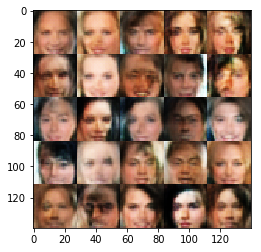

Epoch 1/1 Step 2210... Discriminator Loss: 1.2541... Generator Loss: 0.9184
Epoch 1/1 Step 2220... Discriminator Loss: 1.2590... Generator Loss: 0.9270
Epoch 1/1 Step 2230... Discriminator Loss: 1.2920... Generator Loss: 0.7338
Epoch 1/1 Step 2240... Discriminator Loss: 1.2152... Generator Loss: 0.7961
Epoch 1/1 Step 2250... Discriminator Loss: 1.2483... Generator Loss: 0.8291
Epoch 1/1 Step 2260... Discriminator Loss: 1.3087... Generator Loss: 0.7965
Epoch 1/1 Step 2270... Discriminator Loss: 1.2644... Generator Loss: 0.8749
Epoch 1/1 Step 2280... Discriminator Loss: 1.2709... Generator Loss: 0.9595
Epoch 1/1 Step 2290... Discriminator Loss: 1.1896... Generator Loss: 0.8725
Epoch 1/1 Step 2300... Discriminator Loss: 1.2471... Generator Loss: 0.8290


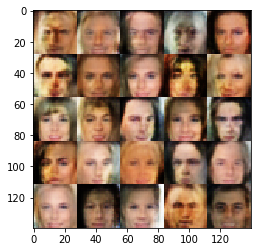

Epoch 1/1 Step 2310... Discriminator Loss: 1.2646... Generator Loss: 0.7529
Epoch 1/1 Step 2320... Discriminator Loss: 1.2750... Generator Loss: 0.9106
Epoch 1/1 Step 2330... Discriminator Loss: 1.3215... Generator Loss: 0.8438
Epoch 1/1 Step 2340... Discriminator Loss: 1.2826... Generator Loss: 0.8391
Epoch 1/1 Step 2350... Discriminator Loss: 1.2791... Generator Loss: 0.9639
Epoch 1/1 Step 2360... Discriminator Loss: 1.3179... Generator Loss: 0.8504
Epoch 1/1 Step 2370... Discriminator Loss: 1.2020... Generator Loss: 0.8884
Epoch 1/1 Step 2380... Discriminator Loss: 1.2800... Generator Loss: 0.9138
Epoch 1/1 Step 2390... Discriminator Loss: 1.3950... Generator Loss: 1.1036
Epoch 1/1 Step 2400... Discriminator Loss: 1.2615... Generator Loss: 0.7456


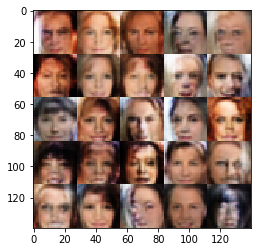

Epoch 1/1 Step 2410... Discriminator Loss: 1.3019... Generator Loss: 0.7228
Epoch 1/1 Step 2420... Discriminator Loss: 1.2326... Generator Loss: 0.9042
Epoch 1/1 Step 2430... Discriminator Loss: 1.2346... Generator Loss: 0.8601
Epoch 1/1 Step 2440... Discriminator Loss: 1.2102... Generator Loss: 0.8657
Epoch 1/1 Step 2450... Discriminator Loss: 1.2761... Generator Loss: 0.7832
Epoch 1/1 Step 2460... Discriminator Loss: 1.2750... Generator Loss: 0.9314
Epoch 1/1 Step 2470... Discriminator Loss: 1.2275... Generator Loss: 0.9637
Epoch 1/1 Step 2480... Discriminator Loss: 1.1347... Generator Loss: 0.9422
Epoch 1/1 Step 2490... Discriminator Loss: 1.2391... Generator Loss: 0.8043
Epoch 1/1 Step 2500... Discriminator Loss: 1.3136... Generator Loss: 0.8994


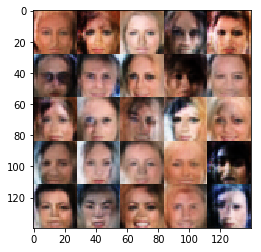

Epoch 1/1 Step 2510... Discriminator Loss: 1.2312... Generator Loss: 0.8398
Epoch 1/1 Step 2520... Discriminator Loss: 1.2299... Generator Loss: 0.8859
Epoch 1/1 Step 2530... Discriminator Loss: 1.2206... Generator Loss: 0.8908
Epoch 1/1 Step 2540... Discriminator Loss: 1.2327... Generator Loss: 0.7823
Epoch 1/1 Step 2550... Discriminator Loss: 1.2393... Generator Loss: 0.8937
Epoch 1/1 Step 2560... Discriminator Loss: 1.2381... Generator Loss: 0.8521
Epoch 1/1 Step 2570... Discriminator Loss: 1.3145... Generator Loss: 1.0343
Epoch 1/1 Step 2580... Discriminator Loss: 1.4716... Generator Loss: 0.5292
Epoch 1/1 Step 2590... Discriminator Loss: 1.3092... Generator Loss: 0.9071
Epoch 1/1 Step 2600... Discriminator Loss: 1.2062... Generator Loss: 0.8768


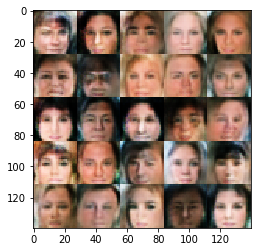

Epoch 1/1 Step 2610... Discriminator Loss: 1.2103... Generator Loss: 0.8628
Epoch 1/1 Step 2620... Discriminator Loss: 1.3027... Generator Loss: 1.0621
Epoch 1/1 Step 2630... Discriminator Loss: 1.2465... Generator Loss: 0.7884
Epoch 1/1 Step 2640... Discriminator Loss: 1.3144... Generator Loss: 1.0109
Epoch 1/1 Step 2650... Discriminator Loss: 1.2187... Generator Loss: 0.7668
Epoch 1/1 Step 2660... Discriminator Loss: 1.2473... Generator Loss: 0.7570
Epoch 1/1 Step 2670... Discriminator Loss: 1.1990... Generator Loss: 0.9606
Epoch 1/1 Step 2680... Discriminator Loss: 1.3022... Generator Loss: 0.7290
Epoch 1/1 Step 2690... Discriminator Loss: 1.2053... Generator Loss: 1.0860
Epoch 1/1 Step 2700... Discriminator Loss: 1.1697... Generator Loss: 0.9462


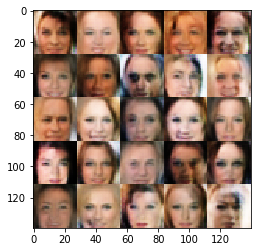

Epoch 1/1 Step 2710... Discriminator Loss: 1.2165... Generator Loss: 0.8712
Epoch 1/1 Step 2720... Discriminator Loss: 1.2796... Generator Loss: 0.7488
Epoch 1/1 Step 2730... Discriminator Loss: 1.3348... Generator Loss: 1.3309
Epoch 1/1 Step 2740... Discriminator Loss: 1.2660... Generator Loss: 0.9829
Epoch 1/1 Step 2750... Discriminator Loss: 1.2116... Generator Loss: 0.8328
Epoch 1/1 Step 2760... Discriminator Loss: 1.2387... Generator Loss: 0.8907
Epoch 1/1 Step 2770... Discriminator Loss: 1.2083... Generator Loss: 0.9277
Epoch 1/1 Step 2780... Discriminator Loss: 1.0077... Generator Loss: 1.0974
Epoch 1/1 Step 2790... Discriminator Loss: 1.2030... Generator Loss: 0.8447
Epoch 1/1 Step 2800... Discriminator Loss: 1.3468... Generator Loss: 0.8238


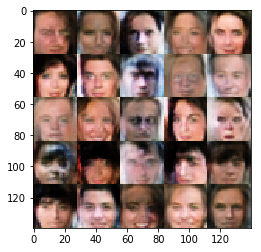

Epoch 1/1 Step 2810... Discriminator Loss: 1.2732... Generator Loss: 0.8440
Epoch 1/1 Step 2820... Discriminator Loss: 1.2404... Generator Loss: 1.0233
Epoch 1/1 Step 2830... Discriminator Loss: 1.2329... Generator Loss: 0.8413
Epoch 1/1 Step 2840... Discriminator Loss: 1.2690... Generator Loss: 0.8868
Epoch 1/1 Step 2850... Discriminator Loss: 1.2590... Generator Loss: 0.9599
Epoch 1/1 Step 2860... Discriminator Loss: 1.1890... Generator Loss: 0.9956
Epoch 1/1 Step 2870... Discriminator Loss: 1.2419... Generator Loss: 0.8340
Epoch 1/1 Step 2880... Discriminator Loss: 1.1639... Generator Loss: 0.9634
Epoch 1/1 Step 2890... Discriminator Loss: 1.2154... Generator Loss: 0.8682
Epoch 1/1 Step 2900... Discriminator Loss: 1.2466... Generator Loss: 0.7902


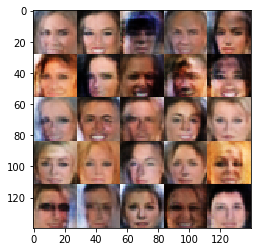

Epoch 1/1 Step 2910... Discriminator Loss: 1.2515... Generator Loss: 0.8677
Epoch 1/1 Step 2920... Discriminator Loss: 1.1508... Generator Loss: 0.8548
Epoch 1/1 Step 2930... Discriminator Loss: 1.0418... Generator Loss: 0.9605
Epoch 1/1 Step 2940... Discriminator Loss: 1.2558... Generator Loss: 0.9825
Epoch 1/1 Step 2950... Discriminator Loss: 1.3135... Generator Loss: 0.7260
Epoch 1/1 Step 2960... Discriminator Loss: 1.3355... Generator Loss: 0.6610
Epoch 1/1 Step 2970... Discriminator Loss: 1.2478... Generator Loss: 0.7254
Epoch 1/1 Step 2980... Discriminator Loss: 1.1280... Generator Loss: 1.1031
Epoch 1/1 Step 2990... Discriminator Loss: 1.1848... Generator Loss: 1.1063
Epoch 1/1 Step 3000... Discriminator Loss: 1.2323... Generator Loss: 0.8619


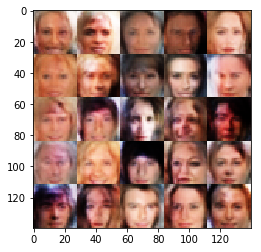

Epoch 1/1 Step 3010... Discriminator Loss: 1.2319... Generator Loss: 1.0420
Epoch 1/1 Step 3020... Discriminator Loss: 1.3575... Generator Loss: 0.8314
Epoch 1/1 Step 3030... Discriminator Loss: 1.2591... Generator Loss: 0.8975
Epoch 1/1 Step 3040... Discriminator Loss: 1.2208... Generator Loss: 0.8579
Epoch 1/1 Step 3050... Discriminator Loss: 1.1732... Generator Loss: 0.9793
Epoch 1/1 Step 3060... Discriminator Loss: 1.2313... Generator Loss: 0.8664
Epoch 1/1 Step 3070... Discriminator Loss: 1.2124... Generator Loss: 0.9383
Epoch 1/1 Step 3080... Discriminator Loss: 1.2753... Generator Loss: 0.7623
Epoch 1/1 Step 3090... Discriminator Loss: 1.2297... Generator Loss: 1.1065
Epoch 1/1 Step 3100... Discriminator Loss: 1.2455... Generator Loss: 1.0369


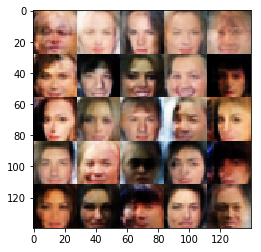

Epoch 1/1 Step 3110... Discriminator Loss: 1.2049... Generator Loss: 0.8355
Epoch 1/1 Step 3120... Discriminator Loss: 1.1526... Generator Loss: 0.9758
Epoch 1/1 Step 3130... Discriminator Loss: 1.3332... Generator Loss: 1.4210
Epoch 1/1 Step 3140... Discriminator Loss: 1.1723... Generator Loss: 1.1090
Epoch 1/1 Step 3150... Discriminator Loss: 1.1614... Generator Loss: 0.9824
Epoch 1/1 Step 3160... Discriminator Loss: 1.1520... Generator Loss: 1.1060
Epoch 1/1 Step 3170... Discriminator Loss: 1.1904... Generator Loss: 0.9234
Epoch 1/1 Step 3180... Discriminator Loss: 1.3380... Generator Loss: 0.6195
Epoch 1/1 Step 3190... Discriminator Loss: 1.2181... Generator Loss: 0.8747
Epoch 1/1 Step 3200... Discriminator Loss: 1.2442... Generator Loss: 0.8511


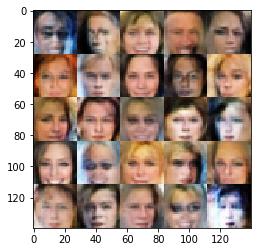

Epoch 1/1 Step 3210... Discriminator Loss: 1.2161... Generator Loss: 0.7566
Epoch 1/1 Step 3220... Discriminator Loss: 1.2406... Generator Loss: 1.0943
Epoch 1/1 Step 3230... Discriminator Loss: 1.1630... Generator Loss: 1.0960
Epoch 1/1 Step 3240... Discriminator Loss: 1.2310... Generator Loss: 0.7255
Epoch 1/1 Step 3250... Discriminator Loss: 1.2100... Generator Loss: 1.2521
Epoch 1/1 Step 3260... Discriminator Loss: 1.2977... Generator Loss: 0.8163
Epoch 1/1 Step 3270... Discriminator Loss: 1.1745... Generator Loss: 1.0148
Epoch 1/1 Step 3280... Discriminator Loss: 1.2166... Generator Loss: 0.9348
Epoch 1/1 Step 3290... Discriminator Loss: 1.2670... Generator Loss: 0.8396
Epoch 1/1 Step 3300... Discriminator Loss: 1.2672... Generator Loss: 1.2700


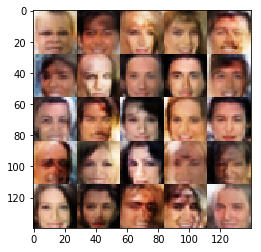

Epoch 1/1 Step 3310... Discriminator Loss: 1.2455... Generator Loss: 0.9377
Epoch 1/1 Step 3320... Discriminator Loss: 1.0804... Generator Loss: 1.0137
Epoch 1/1 Step 3330... Discriminator Loss: 1.2076... Generator Loss: 1.1928
Epoch 1/1 Step 3340... Discriminator Loss: 1.1896... Generator Loss: 0.9624
Epoch 1/1 Step 3350... Discriminator Loss: 1.2074... Generator Loss: 0.7609
Epoch 1/1 Step 3360... Discriminator Loss: 1.2911... Generator Loss: 0.6689
Epoch 1/1 Step 3370... Discriminator Loss: 1.6443... Generator Loss: 1.9415
Epoch 1/1 Step 3380... Discriminator Loss: 1.3316... Generator Loss: 0.6814
Epoch 1/1 Step 3390... Discriminator Loss: 1.1717... Generator Loss: 0.8708
Epoch 1/1 Step 3400... Discriminator Loss: 1.1373... Generator Loss: 0.8778


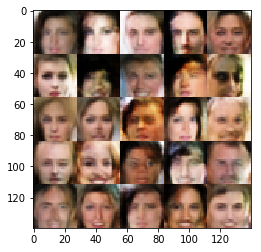

Epoch 1/1 Step 3410... Discriminator Loss: 1.1484... Generator Loss: 0.8908
Epoch 1/1 Step 3420... Discriminator Loss: 1.1756... Generator Loss: 1.0527
Epoch 1/1 Step 3430... Discriminator Loss: 1.1598... Generator Loss: 0.8784
Epoch 1/1 Step 3440... Discriminator Loss: 1.1053... Generator Loss: 0.9494
Epoch 1/1 Step 3450... Discriminator Loss: 1.4441... Generator Loss: 0.5416
Epoch 1/1 Step 3460... Discriminator Loss: 1.0944... Generator Loss: 1.2078
Epoch 1/1 Step 3470... Discriminator Loss: 1.2331... Generator Loss: 0.9510
Epoch 1/1 Step 3480... Discriminator Loss: 1.1651... Generator Loss: 0.9603
Epoch 1/1 Step 3490... Discriminator Loss: 1.1963... Generator Loss: 0.9818
Epoch 1/1 Step 3500... Discriminator Loss: 1.1349... Generator Loss: 1.1780


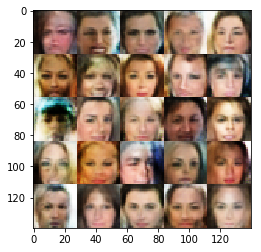

Epoch 1/1 Step 3510... Discriminator Loss: 1.1964... Generator Loss: 1.1133
Epoch 1/1 Step 3520... Discriminator Loss: 1.1718... Generator Loss: 0.9243
Epoch 1/1 Step 3530... Discriminator Loss: 1.0975... Generator Loss: 0.8816
Epoch 1/1 Step 3540... Discriminator Loss: 1.2012... Generator Loss: 0.7715
Epoch 1/1 Step 3550... Discriminator Loss: 1.2222... Generator Loss: 0.9324
Epoch 1/1 Step 3560... Discriminator Loss: 0.9702... Generator Loss: 1.1386
Epoch 1/1 Step 3570... Discriminator Loss: 1.2116... Generator Loss: 0.8751
Epoch 1/1 Step 3580... Discriminator Loss: 1.2497... Generator Loss: 0.7311
Epoch 1/1 Step 3590... Discriminator Loss: 1.2316... Generator Loss: 1.1312
Epoch 1/1 Step 3600... Discriminator Loss: 1.1585... Generator Loss: 0.8786


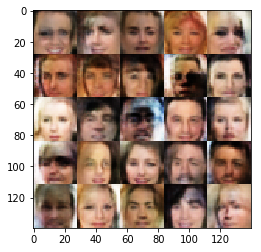

Epoch 1/1 Step 3610... Discriminator Loss: 1.3512... Generator Loss: 0.6306
Epoch 1/1 Step 3620... Discriminator Loss: 1.2491... Generator Loss: 0.7279
Epoch 1/1 Step 3630... Discriminator Loss: 1.1839... Generator Loss: 0.8661
Epoch 1/1 Step 3640... Discriminator Loss: 1.2063... Generator Loss: 0.8729
Epoch 1/1 Step 3650... Discriminator Loss: 1.0884... Generator Loss: 0.9357
Epoch 1/1 Step 3660... Discriminator Loss: 1.1339... Generator Loss: 0.9602
Epoch 1/1 Step 3670... Discriminator Loss: 1.1089... Generator Loss: 0.9234
Epoch 1/1 Step 3680... Discriminator Loss: 1.1183... Generator Loss: 1.0002
Epoch 1/1 Step 3690... Discriminator Loss: 1.1388... Generator Loss: 0.9333
Epoch 1/1 Step 3700... Discriminator Loss: 1.1373... Generator Loss: 0.9550


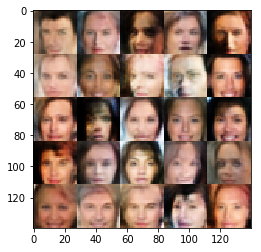

Epoch 1/1 Step 3710... Discriminator Loss: 1.0913... Generator Loss: 0.9304
Epoch 1/1 Step 3720... Discriminator Loss: 1.1775... Generator Loss: 0.9141
Epoch 1/1 Step 3730... Discriminator Loss: 1.1077... Generator Loss: 1.0413
Epoch 1/1 Step 3740... Discriminator Loss: 1.1410... Generator Loss: 1.0681
Epoch 1/1 Step 3750... Discriminator Loss: 1.2001... Generator Loss: 0.8356
Epoch 1/1 Step 3760... Discriminator Loss: 1.2415... Generator Loss: 0.8422
Epoch 1/1 Step 3770... Discriminator Loss: 1.1289... Generator Loss: 1.1547
Epoch 1/1 Step 3780... Discriminator Loss: 1.1576... Generator Loss: 0.9975
Epoch 1/1 Step 3790... Discriminator Loss: 1.1745... Generator Loss: 0.9268
Epoch 1/1 Step 3800... Discriminator Loss: 1.1526... Generator Loss: 0.9967


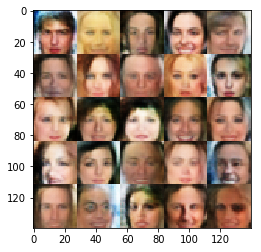

Epoch 1/1 Step 3810... Discriminator Loss: 1.1872... Generator Loss: 0.7990
Epoch 1/1 Step 3820... Discriminator Loss: 1.1296... Generator Loss: 0.8429
Epoch 1/1 Step 3830... Discriminator Loss: 1.1831... Generator Loss: 1.2275
Epoch 1/1 Step 3840... Discriminator Loss: 1.1587... Generator Loss: 0.9584
Epoch 1/1 Step 3850... Discriminator Loss: 1.1777... Generator Loss: 0.9346
Epoch 1/1 Step 3860... Discriminator Loss: 1.1185... Generator Loss: 1.0642
Epoch 1/1 Step 3870... Discriminator Loss: 1.0861... Generator Loss: 1.0231
Epoch 1/1 Step 3880... Discriminator Loss: 1.1656... Generator Loss: 0.9596
Epoch 1/1 Step 3890... Discriminator Loss: 1.1640... Generator Loss: 0.9032
Epoch 1/1 Step 3900... Discriminator Loss: 1.0527... Generator Loss: 1.2428


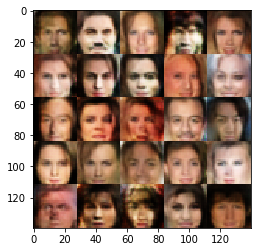

Epoch 1/1 Step 3910... Discriminator Loss: 1.1914... Generator Loss: 1.4823
Epoch 1/1 Step 3920... Discriminator Loss: 1.3154... Generator Loss: 1.5222
Epoch 1/1 Step 3930... Discriminator Loss: 1.0983... Generator Loss: 1.0829
Epoch 1/1 Step 3940... Discriminator Loss: 1.2065... Generator Loss: 0.9569
Epoch 1/1 Step 3950... Discriminator Loss: 1.1860... Generator Loss: 0.9441
Epoch 1/1 Step 3960... Discriminator Loss: 1.1364... Generator Loss: 1.0458
Epoch 1/1 Step 3970... Discriminator Loss: 1.1765... Generator Loss: 0.9812
Epoch 1/1 Step 3980... Discriminator Loss: 1.0935... Generator Loss: 0.9032
Epoch 1/1 Step 3990... Discriminator Loss: 1.0788... Generator Loss: 1.1096
Epoch 1/1 Step 4000... Discriminator Loss: 1.1155... Generator Loss: 0.9115


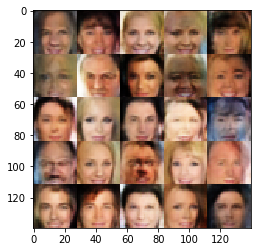

Epoch 1/1 Step 4010... Discriminator Loss: 1.1900... Generator Loss: 0.7596
Epoch 1/1 Step 4020... Discriminator Loss: 1.0723... Generator Loss: 1.0961
Epoch 1/1 Step 4030... Discriminator Loss: 1.1536... Generator Loss: 0.8851
Epoch 1/1 Step 4040... Discriminator Loss: 1.1895... Generator Loss: 0.9982
Epoch 1/1 Step 4050... Discriminator Loss: 1.0297... Generator Loss: 1.2243
Epoch 1/1 Step 4060... Discriminator Loss: 1.0816... Generator Loss: 0.9622
Epoch 1/1 Step 4070... Discriminator Loss: 1.1941... Generator Loss: 0.8833
Epoch 1/1 Step 4080... Discriminator Loss: 1.0648... Generator Loss: 1.1501
Epoch 1/1 Step 4090... Discriminator Loss: 1.1226... Generator Loss: 1.0105
Epoch 1/1 Step 4100... Discriminator Loss: 1.1098... Generator Loss: 1.0014


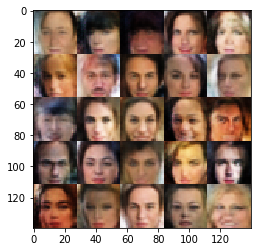

Epoch 1/1 Step 4110... Discriminator Loss: 1.0880... Generator Loss: 1.0309
Epoch 1/1 Step 4120... Discriminator Loss: 1.1286... Generator Loss: 1.2782
Epoch 1/1 Step 4130... Discriminator Loss: 1.2901... Generator Loss: 0.7039
Epoch 1/1 Step 4140... Discriminator Loss: 1.1240... Generator Loss: 0.8724
Epoch 1/1 Step 4150... Discriminator Loss: 1.1198... Generator Loss: 1.3919
Epoch 1/1 Step 4160... Discriminator Loss: 1.2437... Generator Loss: 1.2572
Epoch 1/1 Step 4170... Discriminator Loss: 1.1843... Generator Loss: 1.1384
Epoch 1/1 Step 4180... Discriminator Loss: 1.1538... Generator Loss: 0.9491
Epoch 1/1 Step 4190... Discriminator Loss: 1.0968... Generator Loss: 0.9523
Epoch 1/1 Step 4200... Discriminator Loss: 1.1769... Generator Loss: 0.8652


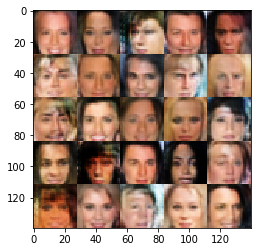

Epoch 1/1 Step 4210... Discriminator Loss: 1.1674... Generator Loss: 0.7915
Epoch 1/1 Step 4220... Discriminator Loss: 1.0943... Generator Loss: 1.0019
Epoch 1/1 Step 4230... Discriminator Loss: 1.1022... Generator Loss: 1.1188
Epoch 1/1 Step 4240... Discriminator Loss: 1.0790... Generator Loss: 0.9823
Epoch 1/1 Step 4250... Discriminator Loss: 1.1396... Generator Loss: 1.0387
Epoch 1/1 Step 4260... Discriminator Loss: 1.1421... Generator Loss: 1.0479
Epoch 1/1 Step 4270... Discriminator Loss: 1.1006... Generator Loss: 1.1545
Epoch 1/1 Step 4280... Discriminator Loss: 1.1127... Generator Loss: 1.2048
Epoch 1/1 Step 4290... Discriminator Loss: 1.0862... Generator Loss: 0.9505
Epoch 1/1 Step 4300... Discriminator Loss: 1.1207... Generator Loss: 1.0206


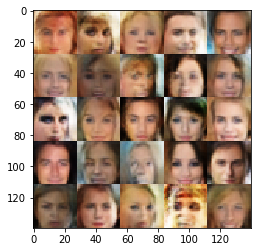

Epoch 1/1 Step 4310... Discriminator Loss: 1.0950... Generator Loss: 1.0840
Epoch 1/1 Step 4320... Discriminator Loss: 1.1847... Generator Loss: 0.9445
Epoch 1/1 Step 4330... Discriminator Loss: 1.1613... Generator Loss: 1.0241
Epoch 1/1 Step 4340... Discriminator Loss: 1.1772... Generator Loss: 0.8109
Epoch 1/1 Step 4350... Discriminator Loss: 1.0950... Generator Loss: 1.0274
Epoch 1/1 Step 4360... Discriminator Loss: 1.2998... Generator Loss: 0.6714
Epoch 1/1 Step 4370... Discriminator Loss: 1.2027... Generator Loss: 0.8030
Epoch 1/1 Step 4380... Discriminator Loss: 1.1037... Generator Loss: 0.9359
Epoch 1/1 Step 4390... Discriminator Loss: 0.9593... Generator Loss: 1.4076
Epoch 1/1 Step 4400... Discriminator Loss: 1.0776... Generator Loss: 1.0665


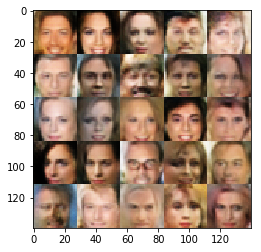

Epoch 1/1 Step 4410... Discriminator Loss: 1.1573... Generator Loss: 1.0688
Epoch 1/1 Step 4420... Discriminator Loss: 1.1529... Generator Loss: 0.9753
Epoch 1/1 Step 4430... Discriminator Loss: 1.1099... Generator Loss: 1.0588
Epoch 1/1 Step 4440... Discriminator Loss: 1.1940... Generator Loss: 0.9890
Epoch 1/1 Step 4450... Discriminator Loss: 1.1279... Generator Loss: 1.1033
Epoch 1/1 Step 4460... Discriminator Loss: 1.3158... Generator Loss: 1.5888
Epoch 1/1 Step 4470... Discriminator Loss: 1.1681... Generator Loss: 0.7463
Epoch 1/1 Step 4480... Discriminator Loss: 1.2585... Generator Loss: 0.6730
Epoch 1/1 Step 4490... Discriminator Loss: 1.1744... Generator Loss: 1.0598
Epoch 1/1 Step 4500... Discriminator Loss: 1.1386... Generator Loss: 0.9057


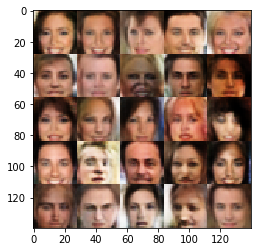

Epoch 1/1 Step 4510... Discriminator Loss: 1.5932... Generator Loss: 0.4029
Epoch 1/1 Step 4520... Discriminator Loss: 1.1945... Generator Loss: 1.1005
Epoch 1/1 Step 4530... Discriminator Loss: 1.0880... Generator Loss: 1.0423
Epoch 1/1 Step 4540... Discriminator Loss: 1.0413... Generator Loss: 1.1032
Epoch 1/1 Step 4550... Discriminator Loss: 1.2316... Generator Loss: 0.7574
Epoch 1/1 Step 4560... Discriminator Loss: 1.0009... Generator Loss: 1.4521
Epoch 1/1 Step 4570... Discriminator Loss: 1.0053... Generator Loss: 1.3751
Epoch 1/1 Step 4580... Discriminator Loss: 1.1433... Generator Loss: 0.8687
Epoch 1/1 Step 4590... Discriminator Loss: 1.0170... Generator Loss: 1.5034
Epoch 1/1 Step 4600... Discriminator Loss: 1.1175... Generator Loss: 1.0842


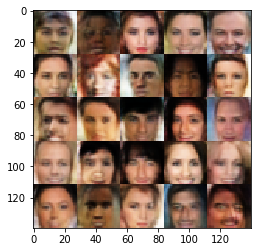

Epoch 1/1 Step 4610... Discriminator Loss: 1.1198... Generator Loss: 0.9260
Epoch 1/1 Step 4620... Discriminator Loss: 1.0509... Generator Loss: 1.0674
Epoch 1/1 Step 4630... Discriminator Loss: 0.9936... Generator Loss: 1.2414
Epoch 1/1 Step 4640... Discriminator Loss: 0.9334... Generator Loss: 1.1331
Epoch 1/1 Step 4650... Discriminator Loss: 1.0369... Generator Loss: 0.9801
Epoch 1/1 Step 4660... Discriminator Loss: 1.0940... Generator Loss: 1.0936
Epoch 1/1 Step 4670... Discriminator Loss: 1.1329... Generator Loss: 1.0853
Epoch 1/1 Step 4680... Discriminator Loss: 1.1509... Generator Loss: 0.7826
Epoch 1/1 Step 4690... Discriminator Loss: 1.1143... Generator Loss: 1.2564
Epoch 1/1 Step 4700... Discriminator Loss: 1.2465... Generator Loss: 1.6036


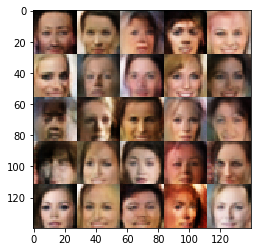

Epoch 1/1 Step 4710... Discriminator Loss: 1.3009... Generator Loss: 1.9548
Epoch 1/1 Step 4720... Discriminator Loss: 1.0584... Generator Loss: 1.0247
Epoch 1/1 Step 4730... Discriminator Loss: 1.1725... Generator Loss: 1.1597
Epoch 1/1 Step 4740... Discriminator Loss: 1.2938... Generator Loss: 1.5461
Epoch 1/1 Step 4750... Discriminator Loss: 1.1010... Generator Loss: 0.9047
Epoch 1/1 Step 4760... Discriminator Loss: 0.9910... Generator Loss: 1.2565
Epoch 1/1 Step 4770... Discriminator Loss: 1.0453... Generator Loss: 0.9358
Epoch 1/1 Step 4780... Discriminator Loss: 0.9779... Generator Loss: 1.1181
Epoch 1/1 Step 4790... Discriminator Loss: 1.0726... Generator Loss: 1.3093
Epoch 1/1 Step 4800... Discriminator Loss: 1.0428... Generator Loss: 1.3577


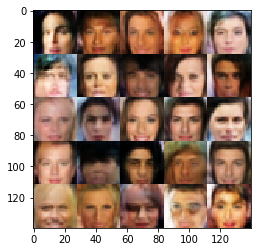

Epoch 1/1 Step 4810... Discriminator Loss: 1.0417... Generator Loss: 1.1749
Epoch 1/1 Step 4820... Discriminator Loss: 1.1534... Generator Loss: 0.9116
Epoch 1/1 Step 4830... Discriminator Loss: 1.0989... Generator Loss: 1.4576
Epoch 1/1 Step 4840... Discriminator Loss: 1.0136... Generator Loss: 1.1798
Epoch 1/1 Step 4850... Discriminator Loss: 1.1077... Generator Loss: 1.2602
Epoch 1/1 Step 4860... Discriminator Loss: 1.0215... Generator Loss: 1.0405
Epoch 1/1 Step 4870... Discriminator Loss: 1.2533... Generator Loss: 0.6144
Epoch 1/1 Step 4880... Discriminator Loss: 1.0909... Generator Loss: 1.0139
Epoch 1/1 Step 4890... Discriminator Loss: 1.0517... Generator Loss: 1.3114
Epoch 1/1 Step 4900... Discriminator Loss: 1.1581... Generator Loss: 1.2013


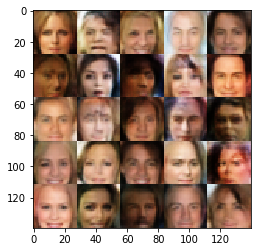

Epoch 1/1 Step 4910... Discriminator Loss: 1.0660... Generator Loss: 1.3401
Epoch 1/1 Step 4920... Discriminator Loss: 1.1122... Generator Loss: 0.8351
Epoch 1/1 Step 4930... Discriminator Loss: 1.0606... Generator Loss: 1.2286
Epoch 1/1 Step 4940... Discriminator Loss: 1.3154... Generator Loss: 1.7480
Epoch 1/1 Step 4950... Discriminator Loss: 0.9954... Generator Loss: 1.4218
Epoch 1/1 Step 4960... Discriminator Loss: 1.0526... Generator Loss: 1.1641
Epoch 1/1 Step 4970... Discriminator Loss: 1.1287... Generator Loss: 0.8200
Epoch 1/1 Step 4980... Discriminator Loss: 0.9366... Generator Loss: 1.4360
Epoch 1/1 Step 4990... Discriminator Loss: 1.0908... Generator Loss: 1.5181
Epoch 1/1 Step 5000... Discriminator Loss: 1.1518... Generator Loss: 0.8871


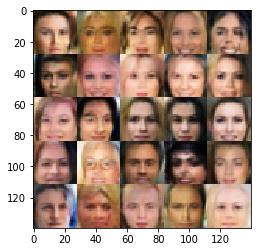

Epoch 1/1 Step 5010... Discriminator Loss: 1.0678... Generator Loss: 1.4311
Epoch 1/1 Step 5020... Discriminator Loss: 1.0739... Generator Loss: 1.0792
Epoch 1/1 Step 5030... Discriminator Loss: 1.0861... Generator Loss: 1.0957
Epoch 1/1 Step 5040... Discriminator Loss: 1.1374... Generator Loss: 1.2836
Epoch 1/1 Step 5050... Discriminator Loss: 1.4307... Generator Loss: 1.6908
Epoch 1/1 Step 5060... Discriminator Loss: 1.0132... Generator Loss: 1.1291
Epoch 1/1 Step 5070... Discriminator Loss: 1.0520... Generator Loss: 1.0521
Epoch 1/1 Step 5080... Discriminator Loss: 1.1278... Generator Loss: 0.8679
Epoch 1/1 Step 5090... Discriminator Loss: 0.9898... Generator Loss: 1.1615
Epoch 1/1 Step 5100... Discriminator Loss: 0.9986... Generator Loss: 1.0725


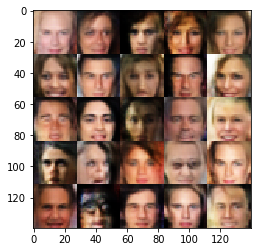

Epoch 1/1 Step 5110... Discriminator Loss: 1.1778... Generator Loss: 0.9020
Epoch 1/1 Step 5120... Discriminator Loss: 1.0839... Generator Loss: 1.0635
Epoch 1/1 Step 5130... Discriminator Loss: 0.9922... Generator Loss: 1.1574
Epoch 1/1 Step 5140... Discriminator Loss: 1.0707... Generator Loss: 0.8950
Epoch 1/1 Step 5150... Discriminator Loss: 1.0217... Generator Loss: 1.1962
Epoch 1/1 Step 5160... Discriminator Loss: 1.2257... Generator Loss: 0.6803
Epoch 1/1 Step 5170... Discriminator Loss: 1.1983... Generator Loss: 1.6915
Epoch 1/1 Step 5180... Discriminator Loss: 0.8884... Generator Loss: 1.3524
Epoch 1/1 Step 5190... Discriminator Loss: 1.0685... Generator Loss: 0.8927
Epoch 1/1 Step 5200... Discriminator Loss: 1.0279... Generator Loss: 1.1058


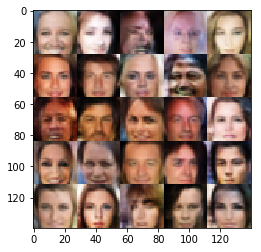

Epoch 1/1 Step 5210... Discriminator Loss: 1.2692... Generator Loss: 0.7078
Epoch 1/1 Step 5220... Discriminator Loss: 1.1297... Generator Loss: 0.8964
Epoch 1/1 Step 5230... Discriminator Loss: 1.0186... Generator Loss: 0.9416
Epoch 1/1 Step 5240... Discriminator Loss: 1.4705... Generator Loss: 0.4712
Epoch 1/1 Step 5250... Discriminator Loss: 1.0088... Generator Loss: 1.0049
Epoch 1/1 Step 5260... Discriminator Loss: 1.0198... Generator Loss: 1.3758
Epoch 1/1 Step 5270... Discriminator Loss: 0.9945... Generator Loss: 1.4022
Epoch 1/1 Step 5280... Discriminator Loss: 1.0822... Generator Loss: 1.6386
Epoch 1/1 Step 5290... Discriminator Loss: 1.0362... Generator Loss: 1.1232
Epoch 1/1 Step 5300... Discriminator Loss: 1.1145... Generator Loss: 1.3383


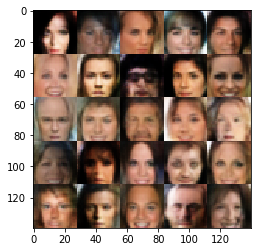

Epoch 1/1 Step 5310... Discriminator Loss: 1.3415... Generator Loss: 0.5687
Epoch 1/1 Step 5320... Discriminator Loss: 1.0295... Generator Loss: 1.1114
Epoch 1/1 Step 5330... Discriminator Loss: 1.0301... Generator Loss: 1.3177
Epoch 1/1 Step 5340... Discriminator Loss: 0.9882... Generator Loss: 1.2384
Epoch 1/1 Step 5350... Discriminator Loss: 1.1469... Generator Loss: 0.7792
Epoch 1/1 Step 5360... Discriminator Loss: 1.1698... Generator Loss: 1.8514
Epoch 1/1 Step 5370... Discriminator Loss: 1.2466... Generator Loss: 0.6665
Epoch 1/1 Step 5380... Discriminator Loss: 1.0292... Generator Loss: 1.0807
Epoch 1/1 Step 5390... Discriminator Loss: 0.9840... Generator Loss: 1.1656
Epoch 1/1 Step 5400... Discriminator Loss: 1.1497... Generator Loss: 0.8545


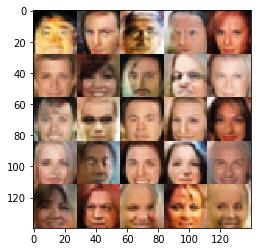

Epoch 1/1 Step 5410... Discriminator Loss: 1.2171... Generator Loss: 0.6951
Epoch 1/1 Step 5420... Discriminator Loss: 1.0383... Generator Loss: 1.6670
Epoch 1/1 Step 5430... Discriminator Loss: 0.9751... Generator Loss: 1.0105
Epoch 1/1 Step 5440... Discriminator Loss: 1.0403... Generator Loss: 1.1992
Epoch 1/1 Step 5450... Discriminator Loss: 1.1658... Generator Loss: 0.8258
Epoch 1/1 Step 5460... Discriminator Loss: 1.2464... Generator Loss: 1.9053
Epoch 1/1 Step 5470... Discriminator Loss: 0.9728... Generator Loss: 1.0199
Epoch 1/1 Step 5480... Discriminator Loss: 1.0232... Generator Loss: 1.0915
Epoch 1/1 Step 5490... Discriminator Loss: 1.0411... Generator Loss: 1.1144
Epoch 1/1 Step 5500... Discriminator Loss: 0.9962... Generator Loss: 1.0081


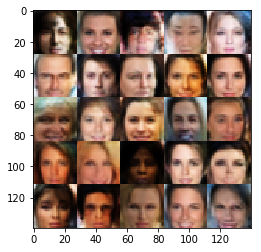

Epoch 1/1 Step 5510... Discriminator Loss: 0.9834... Generator Loss: 1.3027
Epoch 1/1 Step 5520... Discriminator Loss: 0.9662... Generator Loss: 1.5096
Epoch 1/1 Step 5530... Discriminator Loss: 1.0279... Generator Loss: 0.9941
Epoch 1/1 Step 5540... Discriminator Loss: 0.9005... Generator Loss: 1.3416
Epoch 1/1 Step 5550... Discriminator Loss: 1.0447... Generator Loss: 1.0442
Epoch 1/1 Step 5560... Discriminator Loss: 0.9425... Generator Loss: 1.1314
Epoch 1/1 Step 5570... Discriminator Loss: 1.1195... Generator Loss: 0.8267
Epoch 1/1 Step 5580... Discriminator Loss: 0.9302... Generator Loss: 1.1618
Epoch 1/1 Step 5590... Discriminator Loss: 1.0996... Generator Loss: 0.9406
Epoch 1/1 Step 5600... Discriminator Loss: 0.9685... Generator Loss: 1.1500


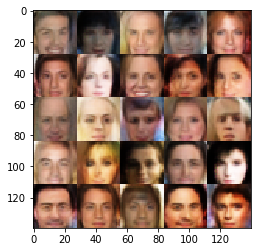

Epoch 1/1 Step 5610... Discriminator Loss: 1.0907... Generator Loss: 1.4812
Epoch 1/1 Step 5620... Discriminator Loss: 1.0927... Generator Loss: 1.0678


In [14]:
batch_size = 36
z_dim = 100
learning_rate = 0.00025
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.